# A multi-task CNN for Human Activity Recognition

Sensor readings from a smartphone can indicate the type of activity performed by the human carrying it.
Usually, inertial sensors such as accelerometers and gyroscopes are used.
<br> This subject is typically referred to as __Human Activity Recognition (HAR)__.

Possible applications for this type of information includes:
* Fitness monitoring. 
* Elder and youth care.
* GPS aiding in denied environments.
* Personal Biometric Signature.

Different types of Machine learning techniques were performed to enable activity recognition from sensor readings. Ranging from basic ML algorithms that relay on extensive feature engineering (see [[3]](#Refs)) to advance deep learning techniques (see [[5]](#Refs)). 

One of the challenges in HAR is that even if the same activity is performed, sensor readings may differ according on the smartphone body position (see [[6]](#Refs)). For example, a person riding a bike: accelerometer readings looks totally different if the smartphone is located in the pocket or on the upper arm.
Even the orientation of a smartphone may differ for a specific position (For example, a smartphone in a backpack may have different orientations).

In this work, we will develop a multi-task CNN that outputs both the activity performed and the smartphone position.
The basic assumption is that both tasks can benefit from having shared lower level features, especially because of the limited amount of training data. 


<a id="Dataset"></a>
## Dataset 

The dataset used can be found in the following 
__[link](https://www.utwente.nl/en/eemcs/ps/research/dataset/)__ under "Sensors activity dataset". Full information regarding this dataset can be found in [[3]](#Refs). 

**The following description is taken from the dataset README file.**

In the data collection experiments, we collected data for seven physical activities.
 These are:
 1. walking
 2. sitting
 3. standing
 4. jogging
 5. biking
 6. walking upstairs
 7. walking downstairs 
 
These are mainly used in the related studies and they are the basic motion
 activities in daily life. There were ten participants involved in our data collection 
 experiment who performed each of these activities for 3-4 minutes. All ten participants
 were male, between the ages of 25 and 30. The experiments were carried out indoors in one
 of the university buildings, except biking. For walking, and jogging, the department 
 corridor was used. For walking upstairs and downstairs, a 5-floor building with stairs
 was used. Each of these participants was equipped with five smartphones on five body
 positions: 
1.	One in their right jean’s pocket. 
2.	One in their left jean’s pocket.
3.	One on belt position towards the right leg using a belt clipper.
4.	One on the right upper arm. 
5.	One on the right wrist.

The first three positions are commonly used by people carrying smartphones. 
The fourth position is usually used when activities like jogging are performed. 
However, we used this position for all activities to see its role on the performance.
  A smart-watch was simulated with the fifth position as smart-watches are coming into
  the market these days.  For these experiments, we used Samsung Galaxy SII (i9100)
  smartphones. 
  The orientation of the smartphones was portrait for the **upper arm**, **wrist**, and **two 
  pockets**, and landscape for the **belt** position. The data was recorded for all five
  positions at the same time for each activity and it was collected at a rate of 50 samples
  per second. This sampling rate (50 samples per second) is enough to recognize human
  physical activities, as we show in our previous study . Moreover, in the state of the
  art, frequencies lower than 50 samples per second have been shown to be sufficient for
  activity recognition.
For data collection, we adapted our own data collection app from our previous study by
 adding the linear acceleration sensor. The data was collected for an accelerometer, 
 a gyroscope, a magnetometer, and a linear acceleration sensor. 

Each excel file contains data for each participant's seven physical activities for all
 five positions. 

Notation in these files: 

* Accelerometer ( Ax = x-axis, Ay = y-axis, Az= Z-aixs)   

* Linear Acceleration Sensor ( Lx = x-axis, Ly = y axis, Lz= Z-aixs) 

* Gyroscope ( Gx = x-axis, Gy = y-axis, Gz= Z-aixs) 

* Magnetometer ( Mx = x-axis, My = y-axis, Mz= Z-aixs) 

<img src="../figures/sensor_positions.png" style="height:500px">


## Dataset  Preprocessing

First of all, let's import several python libraries that will be used through the notebook.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from scipy import stats
import tensorflow as tf
from batchup import data_source
import pickle

# matplotlib and seaborn changes
sns.set(style="darkgrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 

The following code will load the dataset into a python dictionary with participants id's and smartphone positions used as keys. The data for each combination of id and position is stored in a pandas dataframe object.

__cautious!__  participant 8 "upstairs" activity was incorrectly spelled as "upsatirs". A fix was performed in Participant_8 csv file.

In [2]:
path = '../datasets/Activity_Recognition_DataSet/'
ids = ['1','2','3','4','5','6','7','8','9','10']
positions = ['Left_pocket', 'Right_pocket', 'Wrist', 'Upper_arm', 'Belt']
activities = ['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs','downstairs']
columns_specific_position = ['time_stamp','Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz','Gx', 'Gy', 'Gz','Mx', 'My', 'Mz', 'activity']
freq = 50
dt = 1 / freq

In [3]:
# adjust columns names according to sensor position and add activity column
cols = []
for i in range(len(positions)):
    for j in range(len(columns_specific_position)-1):
        cols.append(columns_specific_position[j] + '_' + positions[i])        
cols.append('activity')   

# load data from all participants and store it into a dictionary
db = {}
for id in ids:
    
    # read data
    file_path = path + 'Participant_' + id + '.csv'
    df_id = pd.read_csv(file_path, header=[1])
    
    # set activity column name
    df_id = df_id.rename(columns={'Unnamed: 69': 'activity'})
    
    # delete extra columns
    df_id = df_id.dropna(axis=1,how='all')
    
    # save data according to position
    df_id.columns = cols
    db_pos = {}
    for pos in positions:
        pos_cols = [col for col in df_id.columns if pos in col]
        pos_cols.append('activity')   
        db_pos.update( {pos : df_id.loc[:,pos_cols]} )
        db_pos[pos].columns = columns_specific_position
    
    # save data according to id
    db.update( {id : db_pos} )
  

## Dataset Exploration

Let's perform a simple check of the positions and activity distributions.

In [4]:
pos_count = np.zeros((len(ids), len(positions)), dtype=np.int)
actv_count = np.zeros((len(ids), len(activities)), dtype=np.int)
for i,id in enumerate(ids):
    for j,pos in enumerate(positions):
        # save number of samples for each id and position
        pos_count[i][j] = db[id][pos].shape[0]
        
    for j,actv in enumerate(activities):
        # save number of samples for each id and activity
        df_tmp = db[id][positions[0]]
        actv_count[i][j] = df_tmp[df_tmp.activity == actv].shape[0]

total_count = int(np.sum(np.sum(pos_count, axis=0)))

In [5]:
print('Total amount of samples: ' + str(total_count))
print('')
print('Number of samples according to Participant ID and smartphone position:')
df_pos_count = pd.DataFrame(pos_count, index=ids, columns=positions)     
print(df_pos_count)
print('')
print('Number of samples according to Participant ID and activity type:')
df_actv_count = pd.DataFrame(actv_count, index=ids, columns=activities)     
print(df_actv_count)

Total amount of samples: 3150000

Number of samples according to Participant ID and smartphone position:
    Left_pocket  Right_pocket  Wrist  Upper_arm   Belt
1         63000         63000  63000      63000  63000
2         63000         63000  63000      63000  63000
3         63000         63000  63000      63000  63000
4         63000         63000  63000      63000  63000
5         63000         63000  63000      63000  63000
6         63000         63000  63000      63000  63000
7         63000         63000  63000      63000  63000
8         63000         63000  63000      63000  63000
9         63000         63000  63000      63000  63000
10        63000         63000  63000      63000  63000

Number of samples according to Participant ID and activity type:
    walking  standing  jogging  sitting  biking  upstairs  downstairs
1      9000      9000     9000     9000    9000      9000        9000
2      9000      9000     9000     9000    9000      9000        9000
3      9000   

The dataset samples are evenly distributed across positions and activities.

Next, let's visualize some of the sensor's data.

In [6]:
def PlotActivity(db, id, pos, actv, snsr, time_span, dt, sp_frac ,random_slice = True):
    
    # get number of lines
    dm = round(time_span / dt)

    # get specific dataframe
    df = db[id][pos].loc[db[id][pos].activity == actv].reset_index(drop=True)

    # drope last dm points
    df = df.iloc[0:df.shape[0]-dm,:]
    m = df.shape[0]

    # get time series and chopee
    if random_slice == True:
        sp = rnd.randint(0, m-dm-1)
    else:
        sp = round(sp_frac * m)
    ts = range(sp, sp + dm)
    df = df.iloc[ts,:].reset_index(drop=True)

    # plot X,Y,Z data for selected sensor
    fig, ax = plt.subplots(nrows = 3, figsize = (20, 20), constrained_layout=True)    
    sns.lineplot(x = df.index * dt, y = df[snsr + 'x'], ax=ax[0])
    ax[0].set_title(actv + ' time series example (' + 'ID=' + id + ", pos=" + pos + ", sensor=" + snsr + ")",fontsize=25)
    ax[0].set_ylabel('x',fontsize=20)
    ax[0].set_xlabel("time [sec]",fontsize=20)
    sns.lineplot(x = df.index * dt, y = df[snsr + 'y'], ax=ax[1])
    ax[1].set_title(actv + ' time series example (' + 'ID=' + id + ", pos=" + pos + ", sensor=" + snsr + ")",fontsize=25)
    ax[1].set_ylabel('y',fontsize=20)
    ax[1].set_xlabel("time [sec]",fontsize=20)
    sns.lineplot(x = df.index * dt, y = df[snsr + 'z'], ax=ax[2])
    ax[2].set_title(actv + ' time series example (' + 'ID=' + id + ", pos=" + pos + ", sensor=" + snsr + ")",fontsize=25)
    ax[2].set_ylabel('z',fontsize=20)
    ax[2].set_xlabel("time [sec]",fontsize=20)


We plot the accelerometer readings (all axis) for subject 1 when the smartphone is located in the pocket. A clear periodic pattern is clearly visible. It seems that the pattern has an approximately 1.5 second period.
Additionally, there are different types of patterns corresponding to the different axis. Nevertheless, a strong correlation is present between the the different axis.
<br>
The clear periodic patterns and strong correlation across axis can be exploited by a convolutional neural network (CNN). These characteristics indicates that a useful feature learned in one part of the time series is probably useful in other parts. This is exactly the basic premise of a CNN.

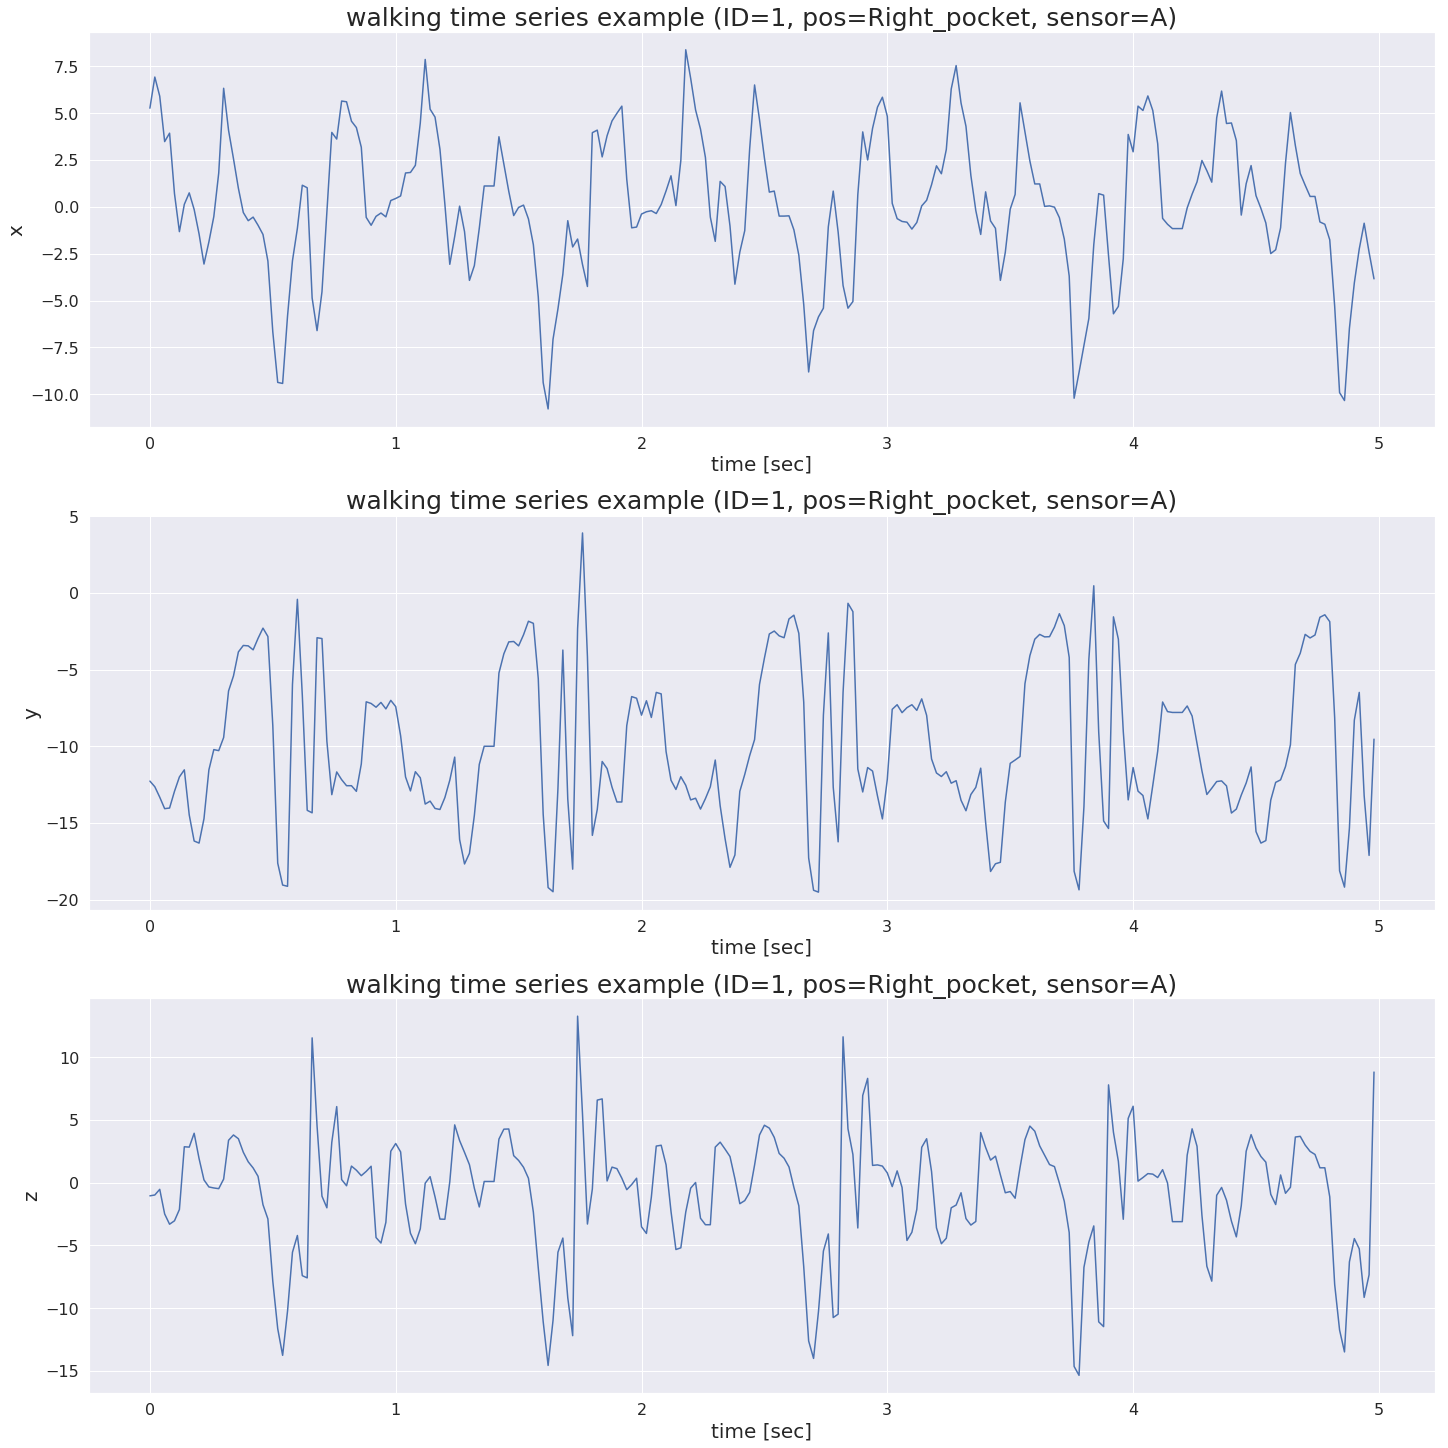

In [7]:
PlotActivity(db, '1', 'Right_pocket', 'walking', 'A', 5.0, dt, 0.5, False)

Similar behavior is observed for other types of sensors. Additionally, strong correlation exists between different sensors.
<br> For example, look at the following gyroscope readings:

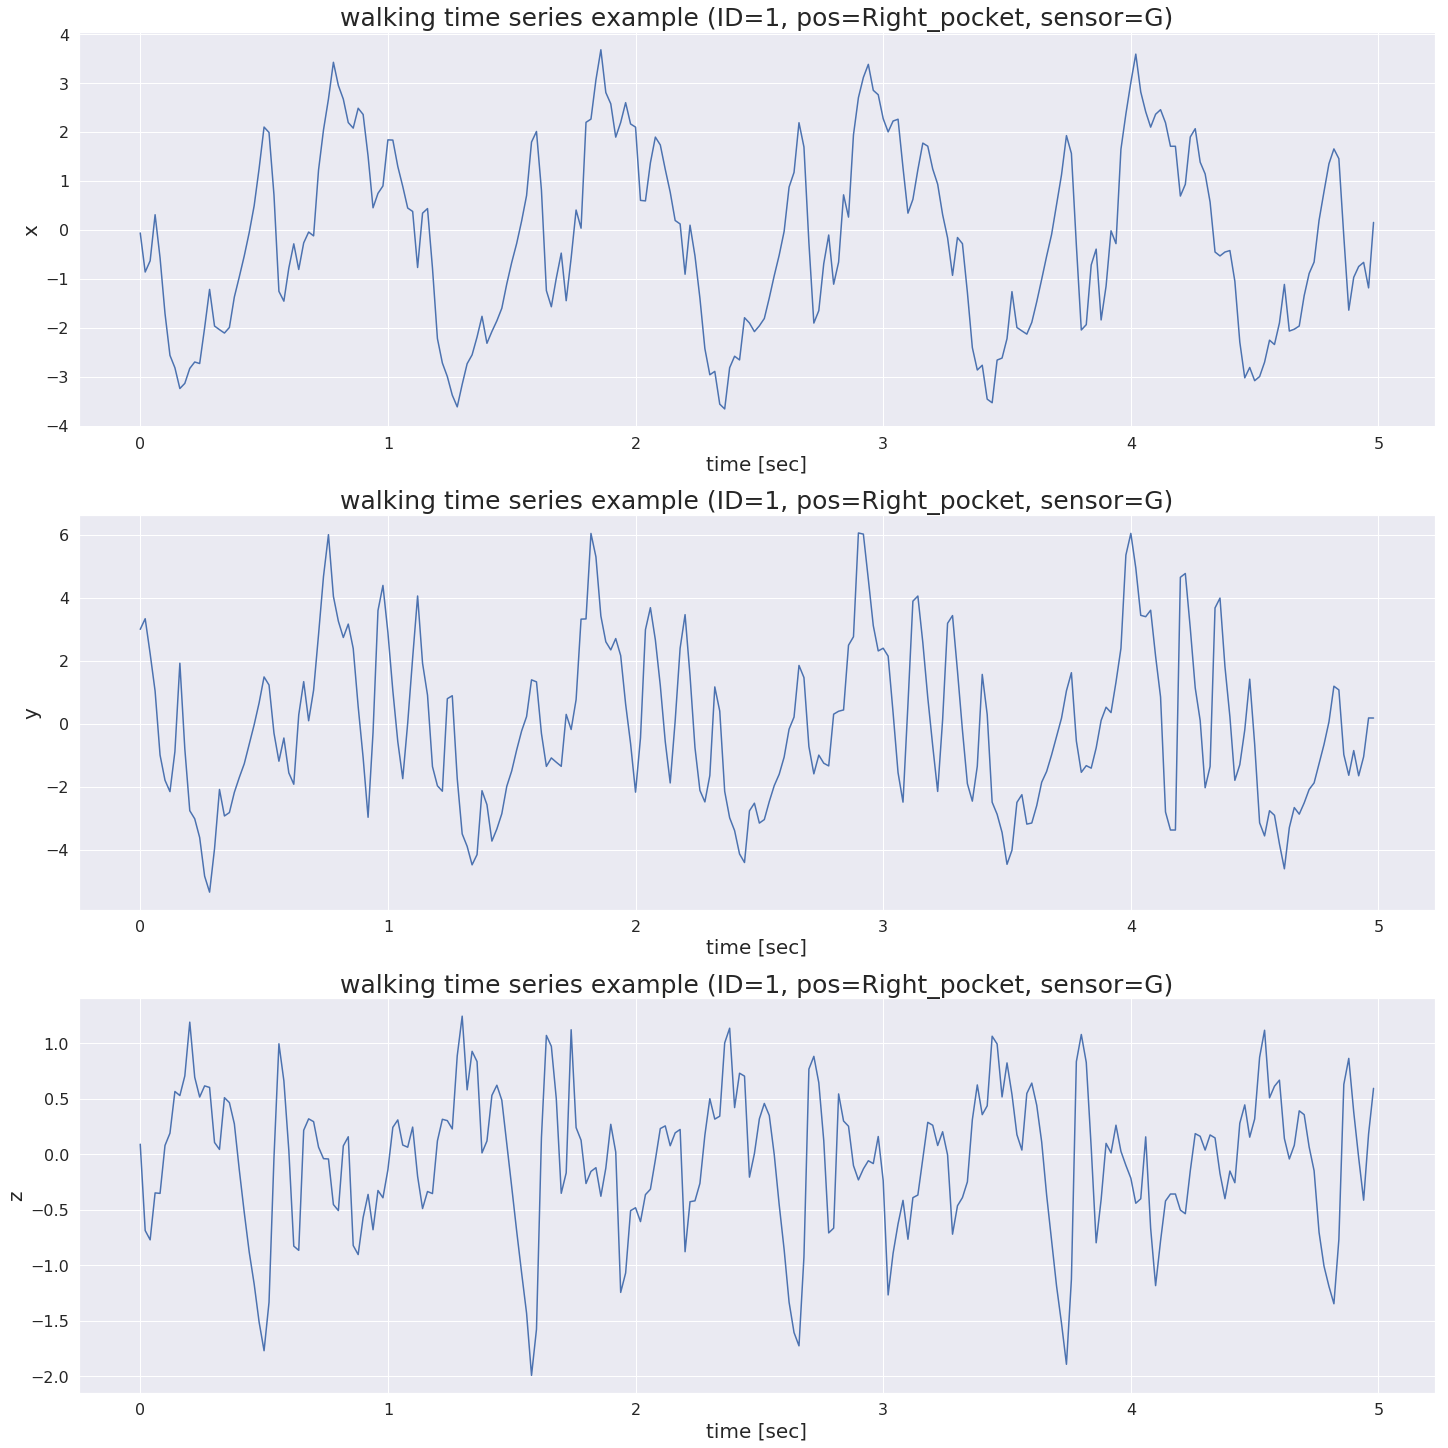

In [8]:
PlotActivity(db, '1', 'Right_pocket', 'walking', 'G', 5.0, dt, 0.5, False)

Next, we plot the accelerometer readings for a static activity.
We can see that no clear periodic pattern exists and that the magnitude of the accelerometer reading is close to the gravity acceleration (9.81 m/s^2).
The main visible difference between standing and sitting is the direction of  gravity in sensor coordinates (Y axis for standing and Z axis for sitting). The gravity direction is an indication of the smartphone orientation. Assuming body to smartphone orientation is fixed, it also serves as an indication of subject body orientation. 

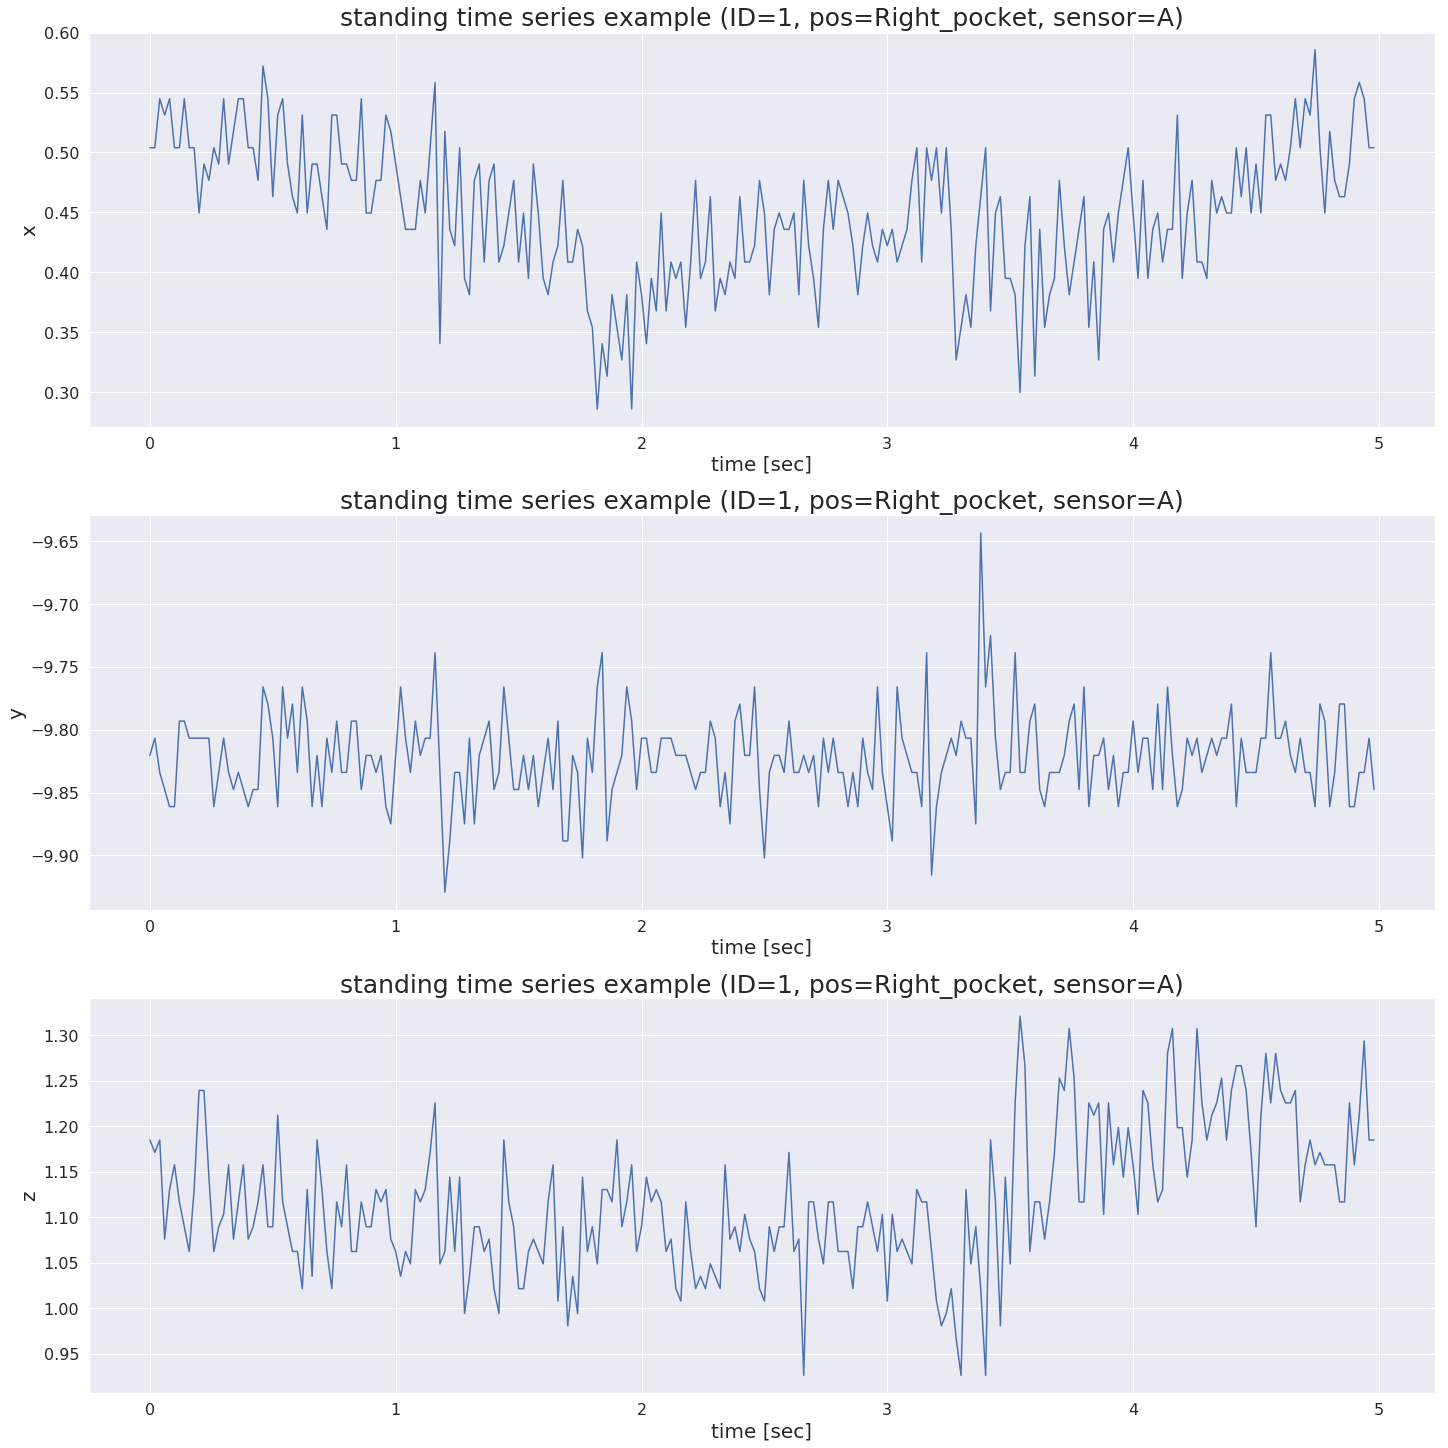

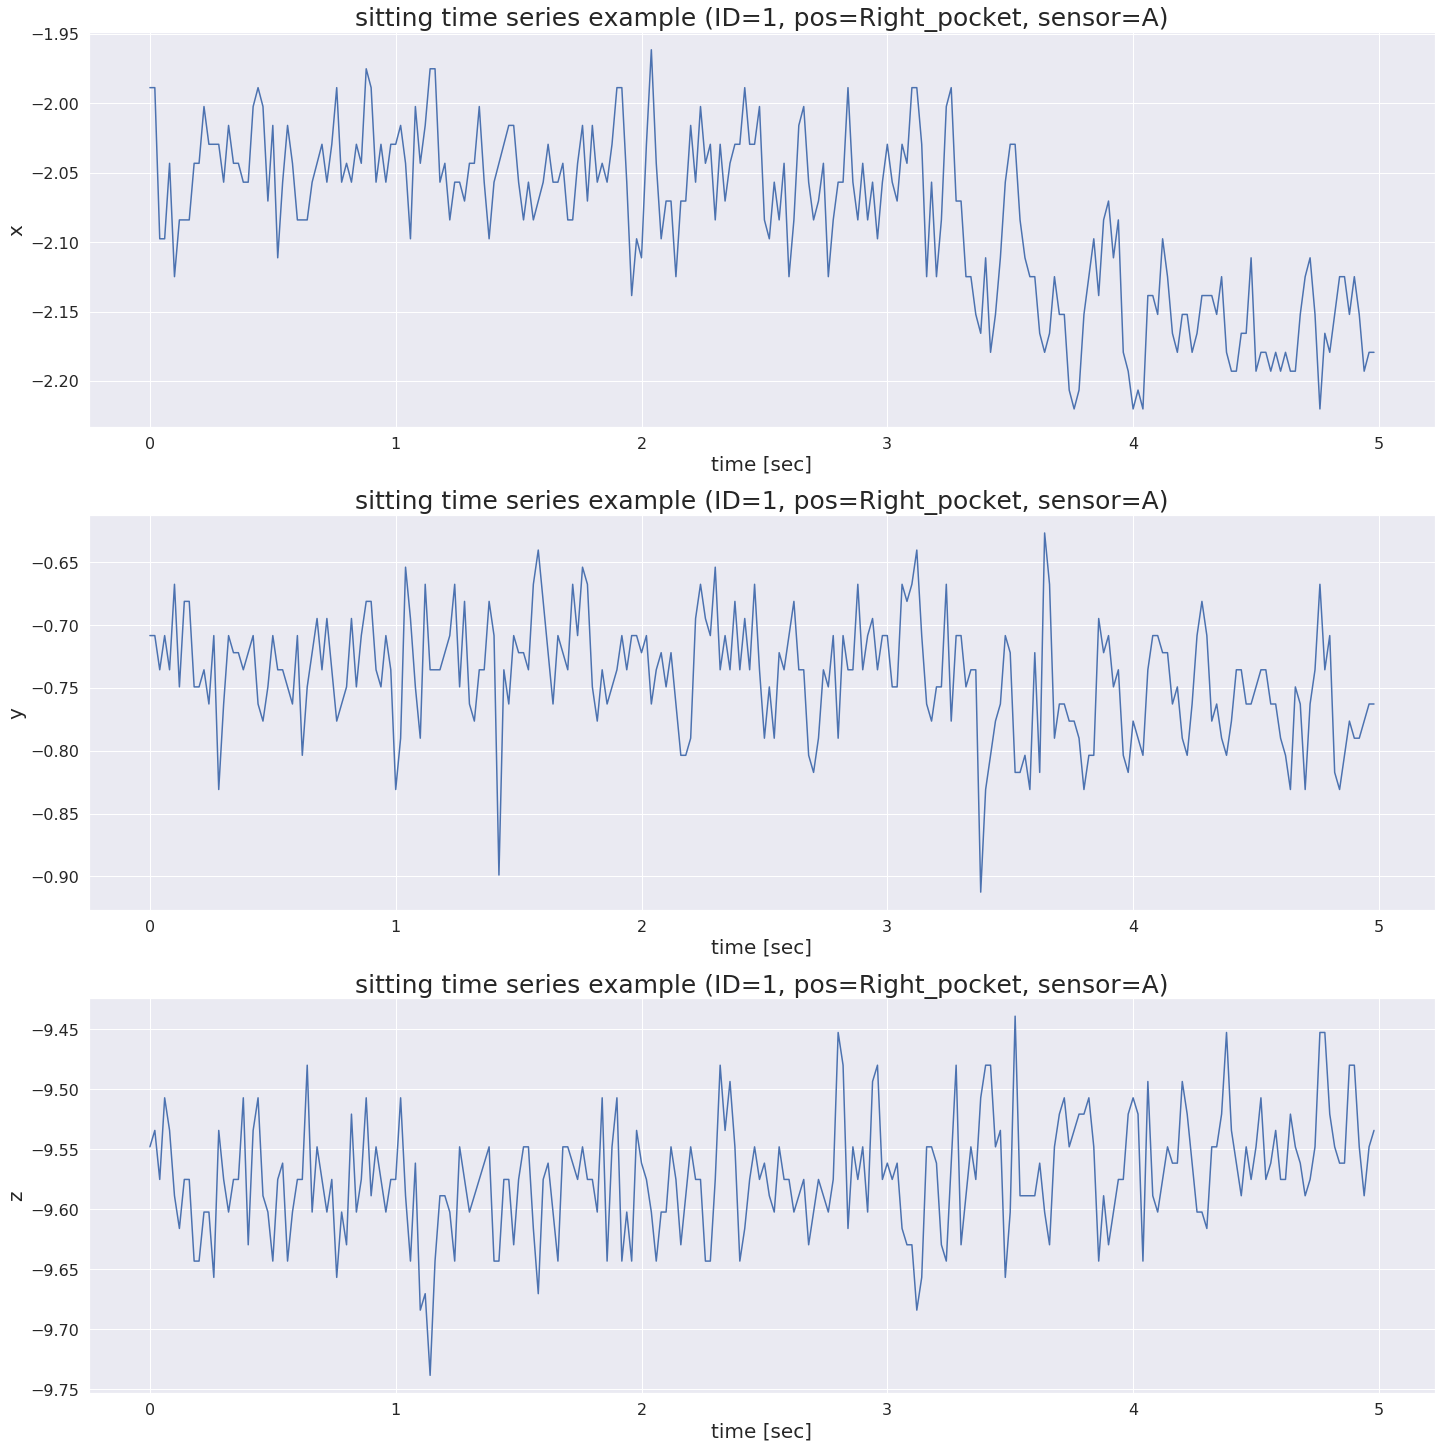

In [9]:
PlotActivity(db, '1', 'Right_pocket', 'standing', 'A', 5.0, dt, 0.6, False)
PlotActivity(db, '1', 'Right_pocket', 'sitting', 'A', 5.0, dt, 0.6, False)

We previously mentioned that the same activity may generate very different sensor readings depending on smartphone position. Lets compare the sensor readings for pocket and upper arm positions while a person is biking.
<br>
We can clearly recognize a smooth and highly periodic pattern in the sensor reading for the pocket position. As expected, the pattern for the upper arm position is totally different. For the arm position, a noisy pattern with relatively small magnitude exist.
<br>
Fortunately, the gyroscope reading seems to maintain a visible pattern even for the upper arm position. The combination of patterns across different sensors may indicate the position of the smartphone.

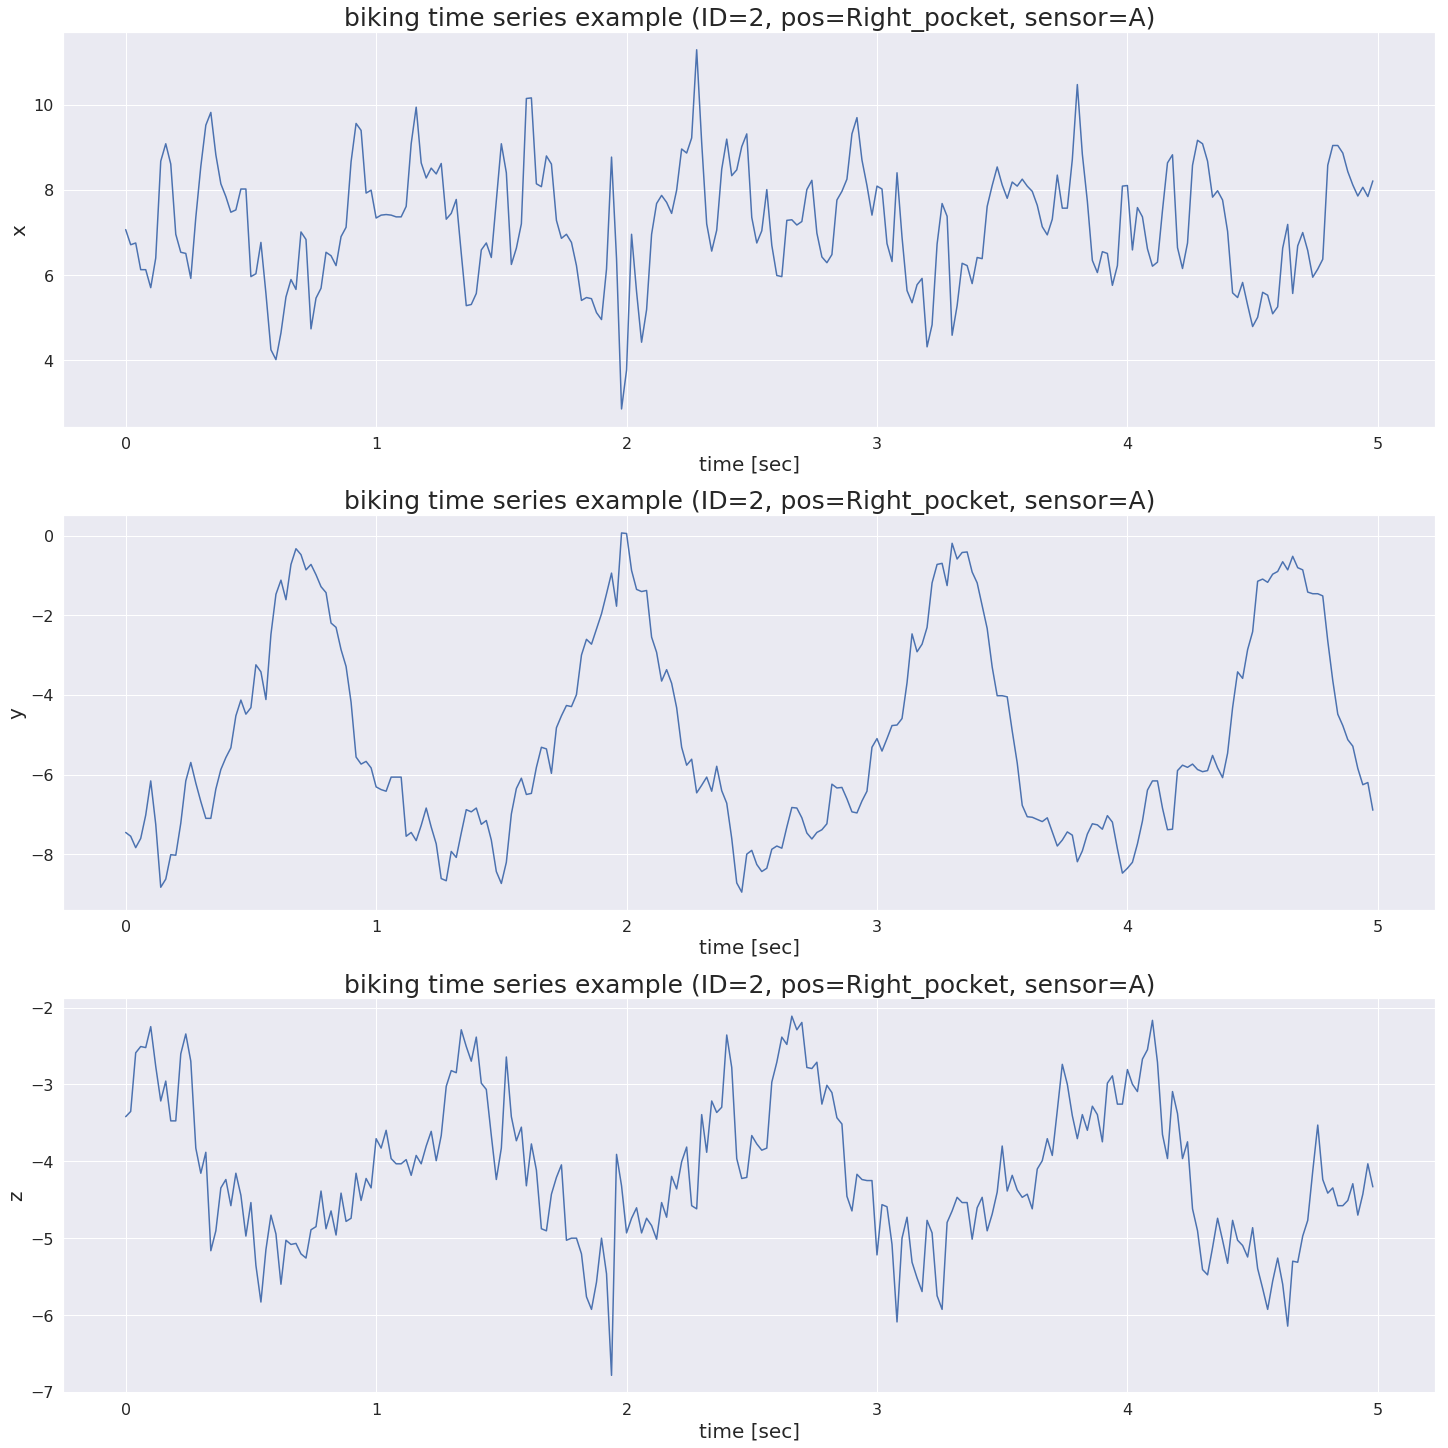

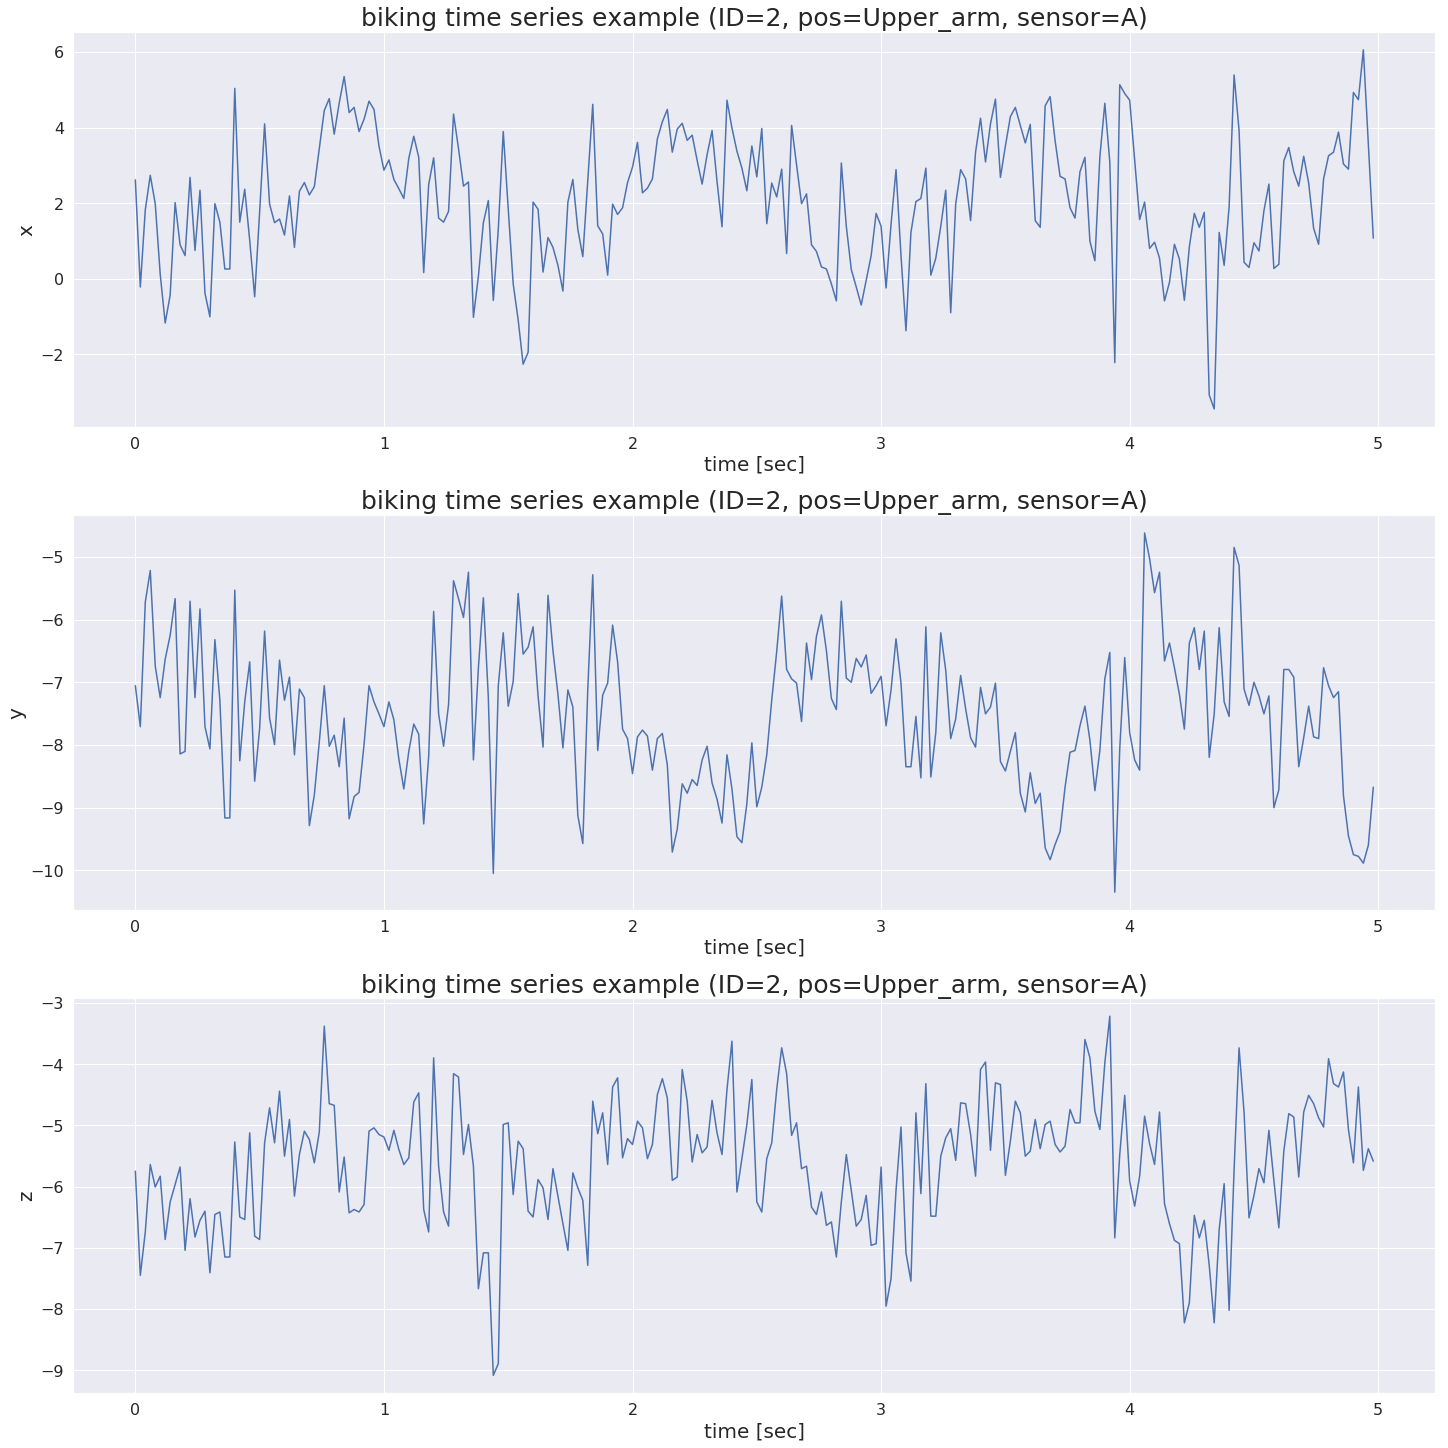

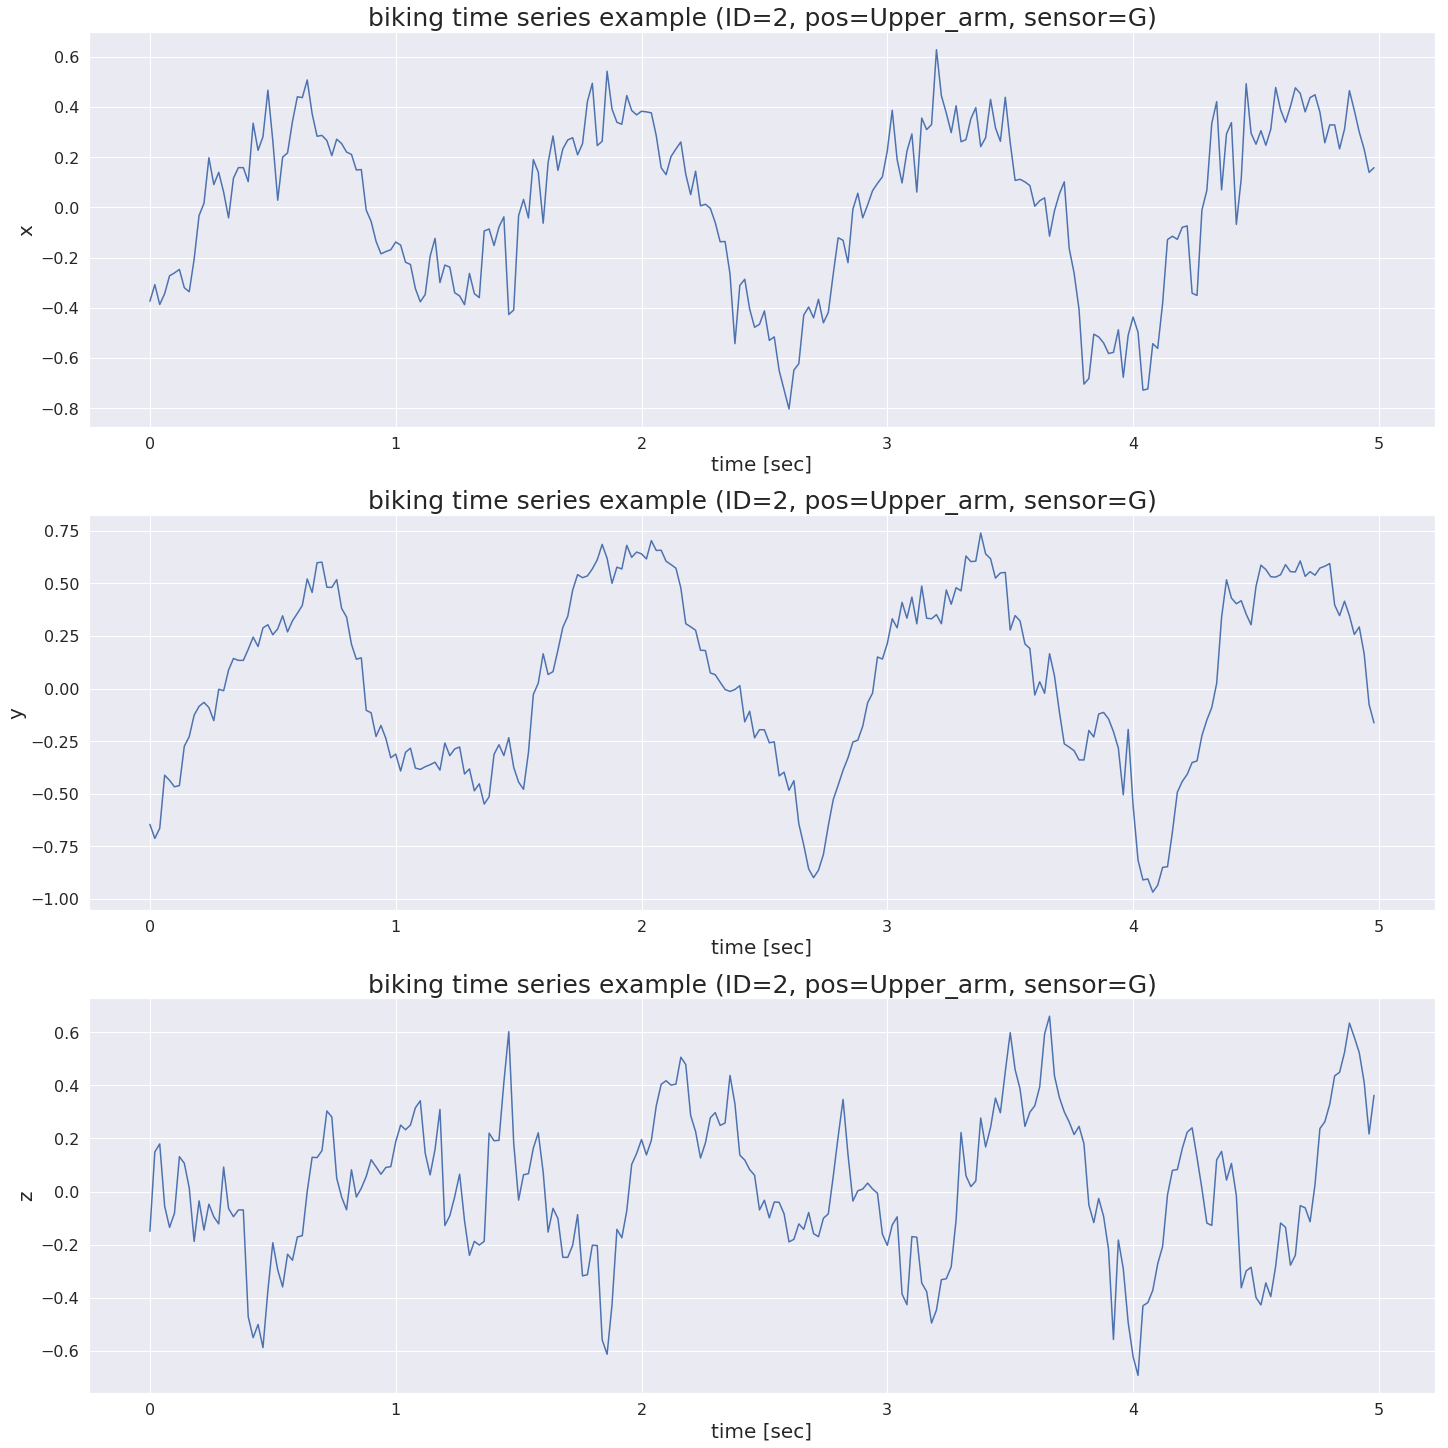

In [10]:
PlotActivity(db, '2', 'Right_pocket', 'biking', 'A', 5.0, dt, 0.6, False)
PlotActivity(db, '2', 'Upper_arm', 'biking', 'A', 5.0, dt, 0.6, False)
PlotActivity(db, '2', 'Upper_arm', 'biking', 'G', 5.0, dt, 0.6, False)

A major challenge in the field of HAR is that is that different
people have different motion patterns (see [[4]](#Refs)). Also, the same person may have different patterns at different times (for example, due to fatigue).
<br>
Let's compare the accelerometer readings for subject 1 and 8 while biking.
Subject 1 has a distinct highly periodic pattern for the accelerometer X and Y directions. The period of the pattern is approximately 2 seconds.
<br>
Subject 8 pattern has a period of approximately 1 second which manifests itself mainly in the Y and Z directions.
<br>
The CNN encounters this phenomenon during training on data from different subjects. As a consequence, robust high-level features would be created.
<br>
For real world applications, an online learning scheme can be employed to learn the motion patterns of a specific user.


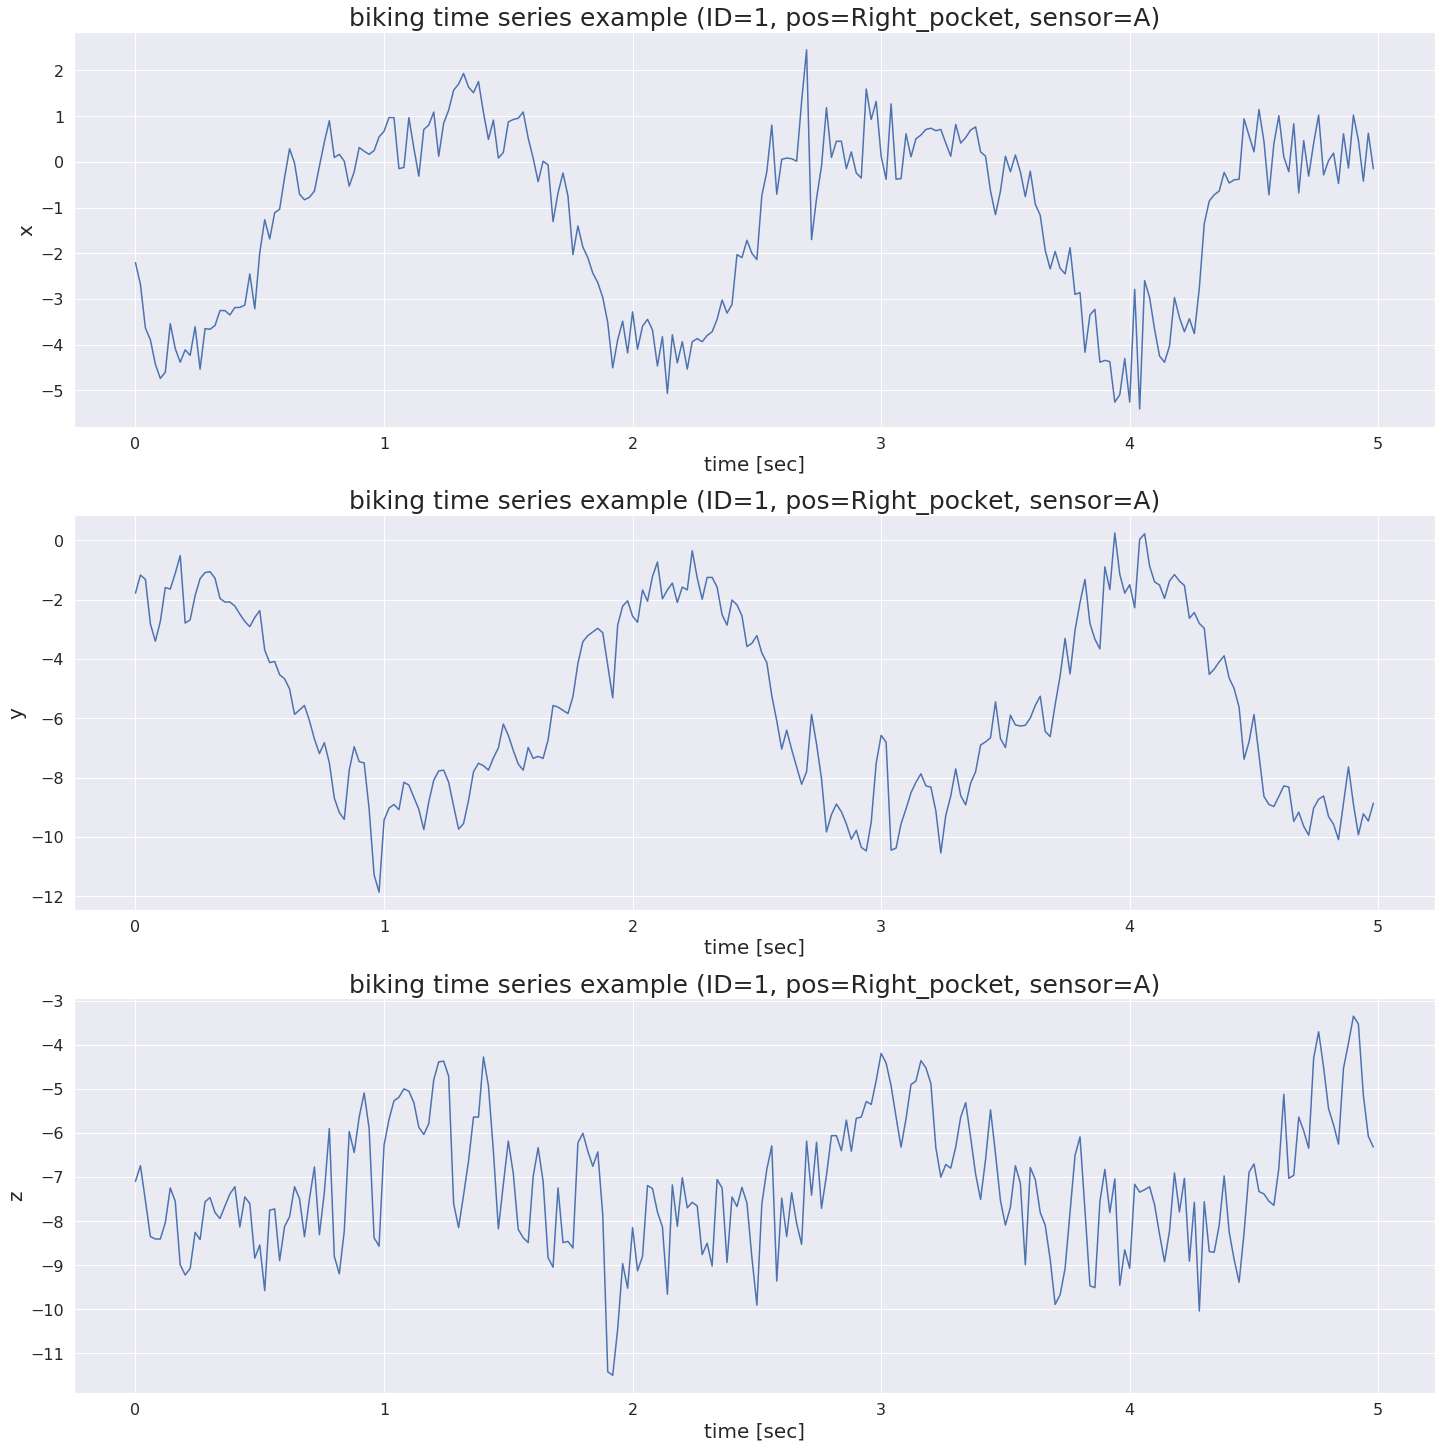

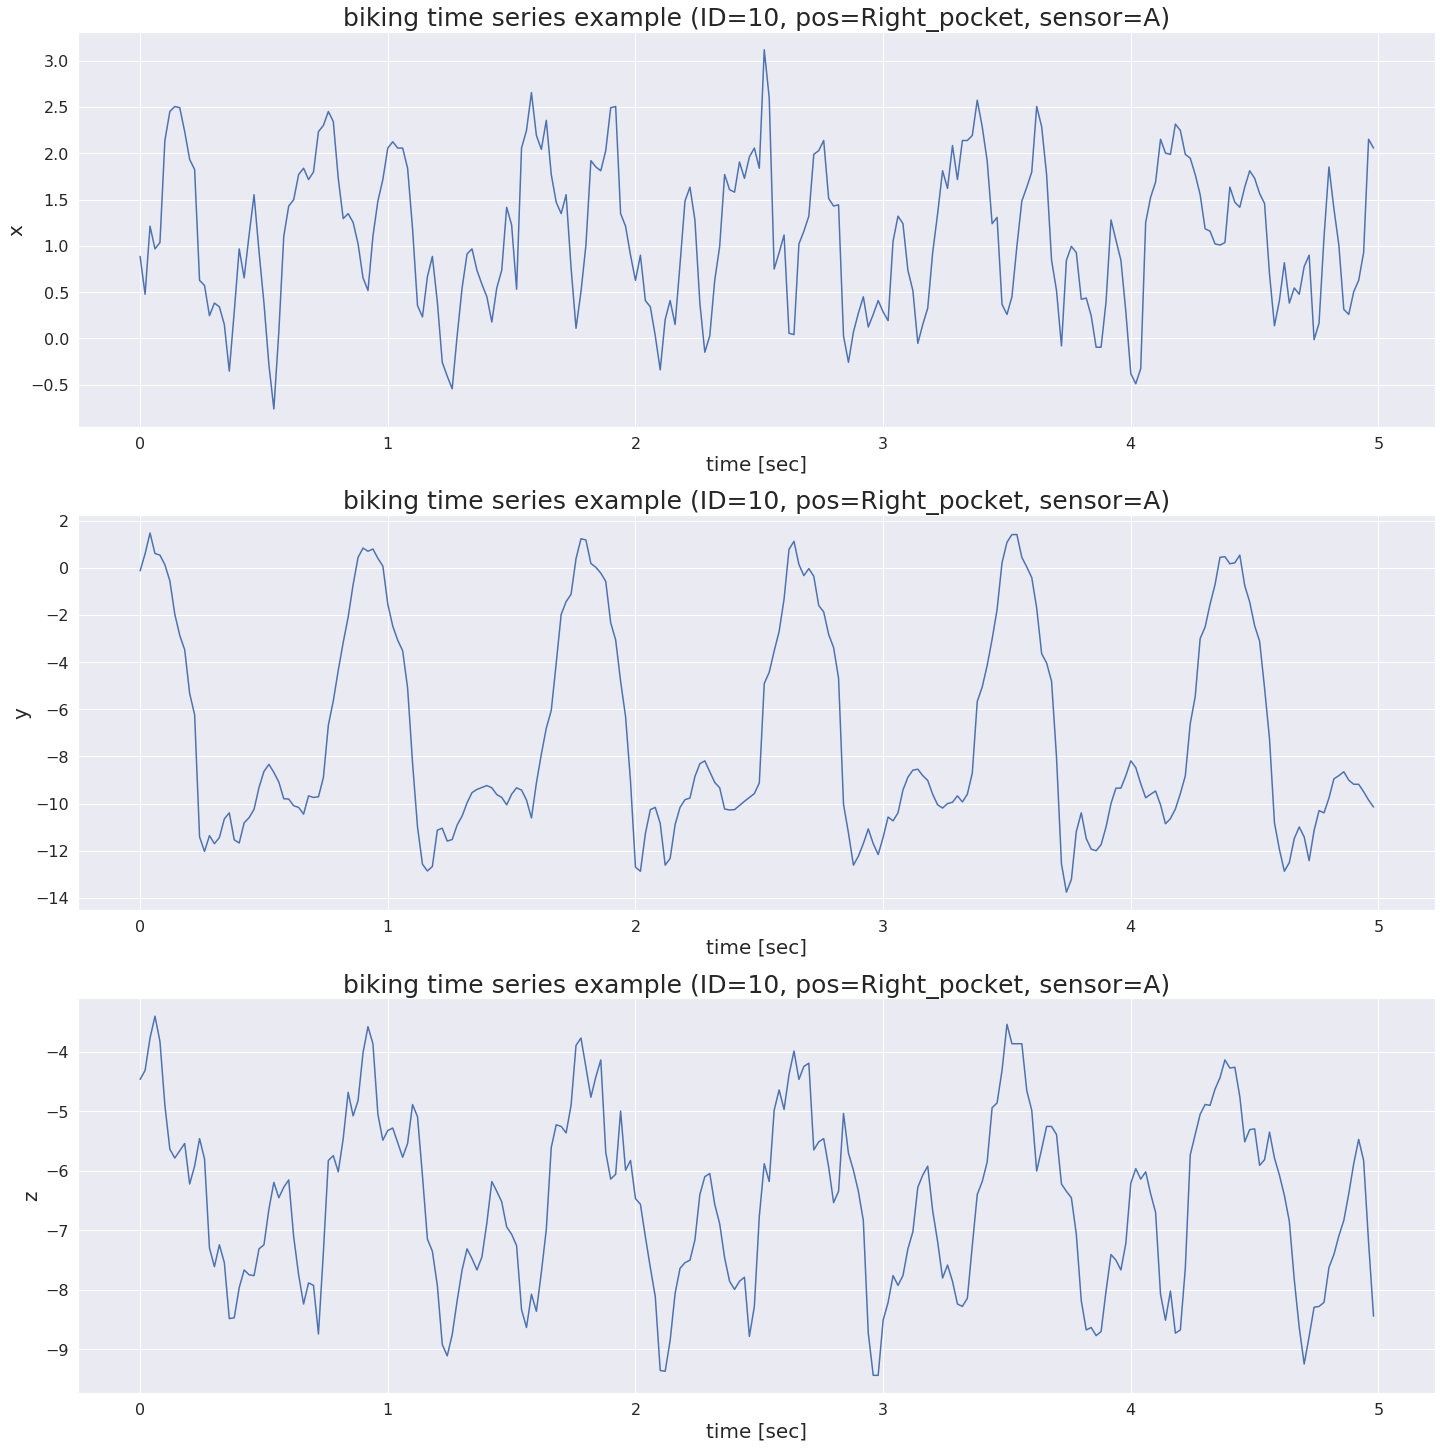

In [11]:
PlotActivity(db, '1', 'Right_pocket', 'biking', 'A', 5.0, dt, 0.2, False)
PlotActivity(db, '10', 'Right_pocket', 'biking', 'A', 5.0, dt, 0.2, False)

## Data Preparation for CNN

As mentioned, periodic patterns and correlation across sensors and directions are especially suitable for a CNN model.

The next step is to prepare the data in a format suitable for a CNN model.
The basic idea is to divide the input data into fixed length 1D time series. The time series for different sensors and directions are then stacked as different channels (like channels in a RGB image). For example, see the following figure (__taken from [[2]](#Refs)__) depicting accelerometers and gyroscopes divided into time series with a fixed length of 128 samples (2.56 seconds) and stacked as different channels.


<img src="../figures/time_series.png" style="height:350px">

Most papers use a 2.5 second time series window size. This window can capture 2-3 cycles of periodic patterns in activities such as walking or stairs climbing. But, the periodic cycle of a biking activity can reach 2 seconds so only a single cycle will be visible in a given time series. Because of this a larger 4 second window was used.  

Adjacent time series can partially overlap. a standard 50% overlap was used.

Next, we need to decide which sensors to use. There are four sensors available: accelerometer, gyroscope, linear acceleration and magnetometer.
<br>The sensor acceleration signal has a gravitational and body motion (linear acceleration) components.
The components are usually separated using a low-pass filter because
the gravitational force is assumed to have only low frequency components. The CNN model itself has the ability of performing this kind of component separation so only the original acceleration input is used.
<br> In addition to the accelerometer sensor, most papers use a gyroscope which measures angular velocity. We have seen that the gyroscope can provide valuable data even in cases were the accelerations are less informative.
<br> The magnetometer is used less often, it was decided not to use it because every extra sensor means extra processing and potentially more battery usage. 

Finally, in order to simplify the classification task two changes where made:

__Delete data associated with Left pocket position__. The left and right pocket readings will have very similar sensor readings. It seems that in most possible HAR applications won't substantially benefit from the specific pocket information. Having an ML algorithm struggling to correctly identify these similar positions seems unnecessary.


__Delete data associated with 'sitting' activity__. In static activities such as laying, sitting or standing the accelerometer and gyroscope will typically have small magnitude and non-periodic readings. In this situations the accelerometer measures mainly the gravity direction which can help to infer the smartphone orientation.
Smartphone orientation can help differentiate between different static activities. But, in real world applications smartphones can have similar orientations even in the case of different static activities. For example, a person watching youtube with his smartphone while standing or sitting will have almost the same smartphone orientation. So, it was decided to try classifying only a single static activity (standing).

An alternative approach was to merged both pocket positions into a unified 'pocket' position and the standing/sitting activities into 'static' activity.
This approach will significantly change the data distribution (create more 'pocket' and 'static' samples relative to other positions/activities). It was decided to first try the more simple 'deleting' approach.

First, we delete the left pocket position and sitting activity.

In [12]:
# delete left pocket position and sitting activity from the dictionary
for id in ids:
    for pos in positions:
        if pos == 'Left_pocket':
            del db[id][pos]
        else:
            df = db[id][pos]
            df = df.drop(df[df.activity == 'sitting'].index).reset_index(drop=True)
            db[id][pos] = df
            
positions = ['Right_pocket', 'Wrist', 'Upper_arm', 'Belt']
activities = ['walking', 'standing', 'jogging', 'biking', 'upstairs','downstairs']           

Then we define some helper functions:

In [13]:
def windows(data, win_size, overlap):
    start = 0
    while start < data.count():
        yield int(start), int(start + win_size)
        start += overlap
        
def segment_signal(db, ids, positions, snsrs, win_size, overlap, approx_num_of_segments):
    
    segments = np.empty((approx_num_of_segments, win_size,len(snsrs)))
    labels = np.empty((approx_num_of_segments,), dtype='U32')
    segment_positions = np.empty((approx_num_of_segments,), dtype='U32')   
    segment_ids = np.empty((approx_num_of_segments,), dtype='U32')
    
    count = 0
    for id in ids:
        for pos in positions:        
            data = db[id][pos]
            for (start, end) in windows(data["time_stamp"], win_size, overlap):
                v = data[snsrs][start:end].values
                if(v.shape[0] == win_size) and (len(data["activity"][start:end].unique()) == 1):
                    segments[count,:,:] = np.dstack(np.transpose(v))
                    labels[count] = stats.mode(data["activity"][start:end])[0][0]
                    segment_positions[count] = pos 
                    segment_ids[count] = id
                    count = count + 1
    
    num_of_segments = count
    ind = range(num_of_segments)
    segments = segments[ind,:,:]
    labels = labels[ind]
    segment_positions = segment_positions[ind]
    segment_ids = segment_ids[ind]
    
    return segments, labels, segment_positions, segment_ids        

Finally, we split the data into segments and encode the position and activity information in a 1-hot format.

In [14]:
win_size = round(4.0 / dt)
overlap_prc = 50.0
overlap = round(overlap_prc / 100 * win_size)
snsrs = ['Ax','Ay','Az','Gx','Gy','Gz']

In [15]:
approx_num_of_segments = len(ids) * len(positions) * db['1']['Right_pocket'].shape[0] / win_size / (overlap_prc/100)
approx_num_of_segments = round(1.1 * approx_num_of_segments)

In [16]:
# split data into time series
ts, ts_activity, ts_position, ts_id = segment_signal(db, ids, positions, snsrs, win_size, overlap, approx_num_of_segments)

# 1-hot encoding of activity
ts_activity_1hot = pd.get_dummies(ts_activity)
actv_1hot_encode = ts_activity_1hot.drop_duplicates().reset_index(drop=True)
activity_names = ts_activity_1hot.columns
ts_activity = np.asarray(ts_activity_1hot, dtype = np.int8)


# 1-hot encoding of position
ts_position_1hot = pd.get_dummies(ts_position)
pos_1hot_encode = ts_position_1hot.drop_duplicates().reset_index(drop=True)
position_names = ts_position_1hot.columns
ts_position = np.asarray(ts_position_1hot, dtype = np.int8)

# reshape time series into tensorflow format -[batch, height, width, channels].
ts = ts.reshape(len(ts), 1, win_size, len(snsrs))
print('Shape of time series = ' + str(ts.shape))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Shape of time series = (21360, 1, 200, 6)


We can see that 21360 batches were created, each batch contains 6 different time series (2 sensors, 3 directions per sensor) with a length of 200 samples.

# Train, dev and test split

Before training, the dataset is usually divided into 3 sets. Each set has it's own role:
* Train set - the majority of the data, used for learning.
* Dev set - used for hyperparameter tuning.
* Test set - used to evaluate final model accuracy.

In our case, the splitting is done in a different way mainly because of a 'subject sensitivity' issue. 
As previously mentioned, different subjects can have different motion patterns. Therefore, an operating HAR application would encounter data with a different distribution then the data it was trained on.
The train\dev\test split should take this characteristic into account.

Another consideration regarding the data splitting is that the dataset used has a relatively small number of subjects. So each 'hold out' subject used for the dev\test sets has a major influence on the amount of training data.

The data splitting used in our work is given by:
* Train set - The majority of the data from 9 out of 10 subjects. The set is used for learning.
* Train-dev set - A small 'hold-out' set from the same subjects used in the train set. The set  evaluates generalization performance on data with the same distribution as the training data.
* Dev set - Data from the subject that wasn't included in the train set. The data is used for hyperparameter tuning and focuses the network on more robust features.
* No test set will be used. The final model's accuracy will be evaluated using a 'leave one subject out' cross validation method. 

We are going to develop a multi-task model. The model will have two outputs: activity and smartphone position.

The sensor data collected should be normalized before used in model. Each sensor and each direction is normalized separately using its calculated mean and standard deviation. Statistics from the train set (mean and std) are used to normalize the rest of the data.

The following function performs the data splitting  and normalization:

In [17]:
def data_split_specific_id(ts, ts_activity, ts_position, ts_id, id, ratio):
    
    train = {}
    train_dev = {}
    dev = {}
    
    # train and dev split according to required id
    split = ts_id != id 
    
    train['x'] = ts[split]
    train['y1']  = ts_activity[split] 
    train['y2']  = ts_position[split]
    train['id']   = ts_id[split]

    dev['x'] = ts[~split]
    dev['y1']  = ts_activity[~split] 
    dev['y2']  = ts_position[~split]
    dev['id']   = ts_id[~split]
    
    # train and train_dev split according to required ratio
    split = np.random.rand(train['x'].shape[0]) < ratio
    
    train_dev['x'] = train['x'][split]
    train_dev['y1']  = train['y1'][split] 
    train_dev['y2']  = train['y2'][split]
    train_dev['id']   = train['id'][split]
    
    train['x'] = train['x'][~split]
    train['y1']  = train['y1'][~split] 
    train['y2']  = train['y2'][~split]
    train['id']   = train['id'][~split]

    # normalize train, train_dev and dev 
    train['x'], train_dev['x'], dev['x'] = normalize_datasets(train['x'], train_dev['x'], dev['x'])
    
    return train, train_dev, dev

def normalize_datasets(train_x, train_dev_x, dev_x):
    
    num_of_channels = train_x.shape[3]
    for i in range(num_of_channels):
    
        # get data for specific channle
        snsr_data = train_x[:,0,:,i]
        snsr_data = np.reshape(snsr_data,(-1,1))

        # compute statisitcs
        mue = np.mean(snsr_data)
        std = np.std(snsr_data)

        # normalize train, dev and test sets
        train_x[:,0,:,i] = (train_x[:,0,:,i] - mue) / std
        train_dev_x[:,0,:,i] = (train_dev_x[:,0,:,i] - mue) / std
        dev_x[:,0,:,i] = (dev_x[:,0,:,i] - mue) / std
        
    return train_x, train_dev_x, dev_x
    


Subjects 2-10 are used for training with a 2% train-dev set. The dev set is based on subjct 1.

In [18]:
# split dataset
train, train_dev, dev = data_split_specific_id(ts, ts_activity, ts_position, ts_id, '1', 0.02)

print('Shape of train set = ' + str(train['x'].shape))
print('Shape of train_dev set = ' + str(train_dev['x'].shape))
print('Shape of dev set = ' + str(dev['x'].shape))
print('')

Shape of train set = (18835, 1, 200, 6)
Shape of train_dev set = (389, 1, 200, 6)
Shape of dev set = (2136, 1, 200, 6)



88% of the data is used for training.

## The CNN Model

In previous section we have seen that the input data contains clear periodic patterns and strong correlation across directions and sensors. These type of  characteristics are especially suited for a CNN model. They indicate that a useful feature learned in one part of the time series is probably useful in other parts. 
This is exactly the basic premise of a CNN.

We will develop a multi-task CNN that outputs both the activity performed and the smartphone position.
The basic assumption is that both tasks can benefit from having shared lower level features. This can help boost performance even if only limited amount of data is available for training. 

The model consists of 3 convolution + max pooling layers. After that, the model will have fully connected layer that splits into 2 branches: a activity branch and a position branch. Each branch consists of a fully connected layer followed by a softmax layer.

The model architecture is depicted in the following figure (created with tensorboard).

<img src="../figures/model_architecture.png" >

The basic structure of the inputs and output are given by:

In [19]:
# input and output sizes
input_height = 1
input_width = win_size
num_channels = len(snsrs)
num_labels1 = ts_activity.shape[1]
num_labels2 = ts_position.shape[1]

The CNN model parameters are based on the model developed in [[2]](#Refs) (which didn't employ multi-task learning). The convolution kernel size was chosen in accordance with the visible periodic patterns appearing in the input data.
<br>
The parameters are given by:

In [20]:
# network settings
num_of_kernel = [92, 192, 192]
num_of_conv_layers = len(num_of_kernel)
kernel_size = 11
pool_size = 3
pool_stride = 2
fc_size = [1000, 500]

Next, we define some helper functions:

In [21]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name='weight')

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial, name='bias')

def apply_conv2d(x,kernel_size,depth):
    num_channels = x.get_shape().as_list()[3]    
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))

def conv2d(x, W):
    return tf.nn.conv2d(x,W, strides=[1, 1, 1, 1], padding='SAME')
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')


Some CNN models developed for HAR employ separable convolution. This type of operation doesn't mix features learned from different channels. In previous sections we have seen that strong correlation exists between different sensors and directions. As a result, It was decided not to use this kind of convolution.
<br>
Another option mentioned in the literature is a depthwise convolution. This type of operation employs a separable convolution followed by a mixing stage. The main advantage of this method is that it uses less parameters.
<br>
For simplicity, it was decided to use a standard convolution operation.

Next, we define the CNN model using tensoflow:

In [22]:
tf.reset_default_graph()   

# placeholders 
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y1 = tf.placeholder(tf.float32, shape=[None,num_labels1])
Y2 = tf.placeholder(tf.float32, shape=[None,num_labels2])
keep_prob = tf.placeholder(tf.float32)

# input layer
net = {}  
net['x'] = X

# conv and pool layers
for l in range(num_of_conv_layers):
    
    # conv
    with tf.name_scope('conv_'+str(l+1)):
        if l == 0:
            net['c'+str(l+1)] = apply_conv2d(net['x'],kernel_size,num_of_kernel[l])
        else:
            net['c'+str(l+1)] = apply_conv2d(net['p'+str(l)],kernel_size,num_of_kernel[l])
    
    # max_pool    
    with tf.name_scope('pool'+str(l+1)):    
        net['p'+str(l+1)] = apply_max_pool(net['c'+str(l+1)],pool_size,pool_stride)

#  flattening conv/pool layers output
with tf.name_scope('conv_flattening'):
    shape = net['p'+str(num_of_conv_layers)].get_shape().as_list()
    net['c_flat'] = tf.reshape(net['p'+str(num_of_conv_layers)], [-1, shape[1] * shape[2] * shape[3]])

#  fully connected layer    
with tf.name_scope('fully_connected'):    
    fc_weights1 = weight_variable([shape[1] * shape[2] * shape[3], fc_size[0]])
    fc_biases1 = bias_variable([fc_size[0]])
    net['fc'] = tf.nn.dropout(tf.nn.relu( tf.add(tf.matmul(net['c_flat'], fc_weights1),fc_biases1) ), keep_prob)  

# activity layers - fully connected layer
with tf.name_scope('actv_fully_connected'):    
    out_weights11 = weight_variable([fc_size[0], fc_size[1]])
    out_biases11 = bias_variable([fc_size[1]])
    net['fc1'] = tf.nn.dropout(tf.nn.relu( tf.add(tf.matmul(net['fc'], out_weights11),out_biases11) ), keep_prob)  

# activity layers - softmax layer    
with tf.name_scope('actv_softmax'):    
    out_weights12 = weight_variable([fc_size[1], num_labels1])
    out_biases12 = bias_variable([num_labels1])
    net['z1'] = tf.matmul(net['fc1'], out_weights12) + out_biases12
    net['a1'] = tf.nn.softmax(net['z1'])

# position layers - fully connected layer
with tf.name_scope('pos_fully_connected'):   
    out_weights21 = weight_variable([fc_size[0], fc_size[1]])
    out_biases21 = bias_variable([fc_size[1]])
    net['fc2'] = tf.nn.dropout(tf.nn.relu( tf.add(tf.matmul(net['fc'], out_weights21),out_biases21) ), keep_prob)       

# position layers - softmax layer        
with tf.name_scope('pos_softmax'):        
    out_weights22 = weight_variable([fc_size[1], num_labels2])
    out_biases22 = bias_variable([num_labels2])
    net['z2'] = tf.matmul(net['fc2'], out_weights22) + out_biases22
    net['a2'] = tf.nn.softmax(net['z2'])        

Large amounts of trainable parameters learned with limited amount of data are prone to overfitting. This situation leads to poor generalization performance.
To prevent overfitting, two types of regularization are implemented: dropout and l2 regularization.
<br> dropout is employed on the fully connected layers and a l2 term is added to the total loss function.

The loss function used for multi-class classification problems is the cross entropy function. In the case of a multi-task learning problem the loss function is the sum of multiple cross entropy functions, one for each task. In our case, The loss is the sum of the activity and position cross entropies. As mentioned, an l2 regularization term is added.

In [23]:
# cross_entropy loss function
with tf.name_scope('cross_entropy'):
    lmbd = tf.placeholder(tf.float32)
    tvars = tf.trainable_variables() 
    l2 = tf.add_n([ tf.nn.l2_loss(v) for v in tvars
                        if 'bias' not in v.name ])
    loss1 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y1, logits=net['z1'])
    loss2 = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y2, logits=net['z2'])    
    loss = tf.reduce_mean(loss1 + loss2 + lmbd * l2)


The training process tries to find the weights that brings the loss function to a minimum. The process of tuning the weights is performed by a numerical optimization techniques (for example: gradient descent) that uses current weights and gradients. 
<br>
The optimizer used in our case is the Adam optimizer. This optimizer can speed up learning when using a mini-batch approach by computing the local average and variance of the gradient and adjusting the learning rate.


In [24]:
# optimizer
with tf.name_scope('optimizer'):    
    lr = tf.placeholder(tf.float32)    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

Some performance related variables are defined. There will be used in the performance and error analysis stage.

In [25]:
with tf.name_scope('activity_performance'):
    predictions1 = tf.argmax(net['a1'],1)
    correct_prediction1 = tf.equal(predictions1, tf.argmax(Y1,1))
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))
    confusion1 = tf.confusion_matrix(labels=tf.argmax(Y1,1), predictions=tf.argmax(net['a1'],1))  
    
with tf.name_scope('position_performance'):
    predictions2 = tf.argmax(net['a2'],1)
    correct_prediction2 = tf.equal(predictions2, tf.argmax(Y2,1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32))
    confusion2 = tf.confusion_matrix(labels=tf.argmax(Y2,1), predictions=tf.argmax(net['a2'],1))      


Before training, let's combine the major tensorflow variables and optimization settings into python dictionaries:

In [26]:
# main tensorflow variables
model = {'optimizer': optimizer, 'loss': loss,
        'predictions1': predictions1, 'accuracy1': accuracy1, 'confusion1': confusion1,
        'predictions2': predictions2, 'accuracy2': accuracy2, 'confusion2': confusion2}

# optimization settings - learning and regularization
params = {'batch_size' : 1024, 'learning_rate' : 0.0001, 'lmbd_l2' : 0.15,
          'Pkeep' : 0.5, 'epochs' : 100}

Finally, we define a function for training and a function for computing performance related variables.

In [27]:
def model_train(model, params, train, test, show_log = False):

    # get parameters from params dict
    epochs = params['epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    lmbd_l2 = params['lmbd_l2']
    Pkeep = params['Pkeep']

    # create a batchup object that can create random batches from the training data
    ds = data_source.ArrayDataSource([train['x'], train['y1'], train['y2']])

    # create tensorflow session
    saver = tf.train.Saver()
    with tf.Session() as sess:

        # init operations
        tf.global_variables_initializer().run()
        train_acc = np.zeros((epochs,2),dtype=float) # store training accuracy
        test_acc = np.zeros((epochs,2),dtype=float)  # store teseting acuuracy

        # loop over epochs
        for epoch in range(epochs):

            # create random batches       
            for (batch_x, batch_y1, batch_y2) in ds.batch_iterator(batch_size=batch_size, shuffle=True):    

                # run optimizer on current batch    
                sess.run([model['optimizer']],feed_dict=
                            {X: batch_x, Y1 : batch_y1, Y2 : batch_y2,
                             keep_prob : Pkeep, lmbd : lmbd_l2, lr : learning_rate})

            # compute training set accuracy at end of epoch
            acc1, acc2 = sess.run([model['accuracy1'], model['accuracy2']], 
                                      feed_dict={X: train['x'], Y1: train['y1'], Y2: train['y2'],
                                                 keep_prob : 1.0, lmbd : lmbd_l2, lr : learning_rate})   
            train_acc[epoch,:] = [acc1, acc2]     

            # compute test set accuracy at end of epoch        
            acc1, acc2 = sess.run([model['accuracy1'], model['accuracy2']],
                                     feed_dict={X: test['x'], Y1: test['y1'], Y2: test['y2'],
                                                keep_prob : 1.0, lmbd : lmbd_l2, lr : learning_rate})   
            test_acc[epoch,:] = [acc1, acc2]  

            # print accuracies
            if show_log == True:
                print ("Epoch: ",epoch,"Activity training accuracy: ", round(train_acc[epoch,0],2),
                       " Activity testing accuracy: ", round(test_acc[epoch,0],2))
                print ("Epoch: ",epoch,"Position training accuracy: ", round(train_acc[epoch,1],2),
                       " Position testing accuracy: ", round(test_acc[epoch,1],2))     
                print("...")
            
            # break if model is overfitting
            if abs(train_acc[epoch,0] - 1.0) < 0.01 and abs(train_acc[epoch,1] - 1.0) < 0.01:
                train_acc[epoch : ,:] = train_acc[epoch ,:] 
                test_acc[epoch : ,:] = test_acc[epoch ,:]                 
                break
                
            # break if model is underfitting
            if (epoch / epochs > 0.5) and (train_acc[epoch,0] < 0.5 or train_acc[epoch,1] < 0.5):
                train_acc[epoch : ,:] = train_acc[epoch ,:] 
                test_acc[epoch : ,:] = test_acc[epoch ,:]                 
                break
                          
        # Save the variables to disk.
        save_path = saver.save(sess, "/tmp/model.ckpt")
        print("Model saved in " + save_path)
        
        # return results
        return train_acc, test_acc
    
def model_performance(model, test):
       
    saver = tf.train.Saver()
    with tf.Session() as sess:
        
        # Restore variables from disk.
        saver.restore(sess, "/tmp/model.ckpt")
        
        # copmute performance related variables - confusion matrices and predictions
        confus1, confus2, pred1, pred2, acc1, acc2 = sess.run(
                                [model['confusion1'] ,model['confusion2'],
                                 model['predictions1'] ,model['predictions2'],
                                 model['accuracy1'], model['accuracy2']],
                                feed_dict={X: test['x'], Y1: test['y1'], Y2: test['y2'],
                                            keep_prob : 1.0, lmbd : 0.0, lr : 0.0})
        
    performance = {'confus1' : confus1, 'confus2' : confus2, 'pred1' : pred1, 'pred2' : pred2,
                   'acc1' : acc1, 'acc2' : acc2}             
        
    return performance
        
        

# Hyperparameter Tuning

A typical Neural Network model depends on many design choices and hyperparameter:
* Learning rate
* Regularization parameters
* Number of layers
* Number of hidden units
* Kernel size
* ...

The model in our work is based on the model developed in [[2]](#Refs). The work done in [[2]](#Refs) included an extensive hyperparameter tuning analysis. After some simple testing, it was concluded that most of the model parameters will stay the same as in [[2]](#Refs). 

A simple random sampling approach was performed to find the best settings for the learning rate and regularization parameters (l2 and dropout).
<br>
The range of possible values for each of the parameters is:
* Learning rate: 0.0001-0.1, sampling on a logarithmic scale
* l2 lambda: 0.001-1.0, sampling on a logarithmic scale
* Dropout keep_prob: 0.3-0.9

The different trained models are evaluated on the dev set. 

In [ ]:
# set the number of random samples 
num_of_samples = 200

# learning rate, l2, dropout, actv train accuracy, position train accuracy, actv test accuracy, position test accuracy
hypr_tune = np.zeros((num_of_samples, 7)) 

# get learning rate random samples
p = -4 + 3*np.random.rand(num_of_samples,1)
hypr_tune[:,0] = np.squeeze(np.power(10, p))

# get l2 lmbd random samples
p = -3 + 3*np.random.rand(num_of_samples,1)
hypr_tune[:,1]  = np.squeeze(np.power(10, p))

# get dropuout keep_prob random samples
hypr_tune[:,2]  = np.squeeze(0.3 + 0.4*np.random.rand(num_of_samples,1))

In [ ]:
# run training on all hyperparemeters combinations
tune_params = {'batch_size' : 1024, 'learning_rate' : 0.0, 'lmbd_l2' : 0.0,
          'Pkeep' : 1.0, 'epochs' : 100}
for i in range(num_of_samples):

    # get unied paramseter values\n",
    tune_params['learning_rate'] = hypr_tune[i,0]
    tune_params['lmbd_l2'] = hypr_tune[i,1]
    tune_params['Pkeep'] = hypr_tune[i,2]    

    # run model and save accuracies\n",
    train_acc, dev_acc = model_train(model, tune_params, train, dev, False)
    hypr_tune[i,3] = train_acc[-1,0] # final activity train accuracy
    hypr_tune[i,4] = train_acc[-1,1] # final position train accuracy    
    hypr_tune[i,5] = dev_acc[-1,0] # final activity test accuracy
    hypr_tune[i,6] = dev_acc[-1,1] # final position test accuracy
    
    print(str(i+1) + ' sample out of ' + str(num_of_samples) 
          + ', train accuracy = ' + str(train_acc[-1,0]) + ', test accuracy = ' + str(dev_acc[-1,0]))    
    print('learning_rate = ' + str(tune_params['learning_rate']))
    print('lmbd_l2 = ' + str(tune_params['lmbd_l2']))
    print('Pkeep = ' + str(tune_params['Pkeep']))
    print('...')          
    
    # save results in dataframe
    df_hypr_tune = pd.DataFrame(hypr_tune, columns=['learning_rate','lmbd_l2','Pkeep',
                                                    'activity_train_accuracy','position_train_accuracy',
                                                    'activity_test_accuracy','position_test_accuracy'])
    df_hypr_tune.to_csv('hyperparameter_tuning/hyperparemeter_tune_results.csv', index=False)

We examine the results and pick the best combination of parameters according to a bias (training accuracy) and variance (difference between training and testing accuracies) criterion. The selected combination is the basis for an an additional manual tuning process.

The final selected hyperparameters are given by:

In [28]:
params = {'batch_size' : 1024, 'learning_rate' : 0.00005, 'lmbd_l2' : 0.16,
          'Pkeep' : 0.5,'epochs' : 200}
print(params)

{'batch_size': 1024, 'learning_rate': 5e-05, 'lmbd_l2': 0.16, 'Pkeep': 0.5, 'epochs': 200}


## Performance and error analysis

After defining the model and tuning it's hyperparameters we are going to examine it's performance.

Due to the 'subject sensitivity' issue and small number of subjects in the dataset, it was decided to use a cross-validation method. The dataset is partitioned into 10 folds, each fold contains data from a different subject. 10 different models are trained, each model uses a different fold as a test set.
For example, the second model uses subject 2 for testing and the rest of the subjects for training.
<br>
The performance metrics of each trained model are computed on 3 datasets:
* Train set - data used for training.
* Train-test set - a small 'hold out' set based on data from the subjects used in the train set.
* Test set - data from the 'hold out' subject.

The model's performance metrics are used to evaluate:
* Bias - the model train accuracy is an indication of underfitting the training data.
* Variance - the model train-test accuracy is an indication of generalization performance on data with the same distribution as the training data.
* Data mismatch - the model test accuracy is and indication of the generalization performance on data coming from a new unseen subject.

In [29]:
def cross_validation(ids, model, params, ts, ts_activity, ts_position, ts_id, frac):

    perform = {}
    acc_history = {}
    datasets = {}
    for id in ids:
        
        # create train, train_dev, dev sets for a specific subject
        train, train_test, test = data_split_specific_id(ts, ts_activity, ts_position, ts_id, id, frac)
        
        # train model
        train_acc, test_acc = model_train(model, params, train, test, False)
        
        # evaluate performance metrics
        perform_train = model_performance(model, train)        
        perform_train_test = model_performance(model, train_test)
        perform_test = model_performance(model, test)
        
        # save performance metrics
        perform_id = {'train': perform_train, 'train_test': perform_train_test, 'test': perform_test}
        perform.update( {id : perform_id} )
        
        # save accuracy history        
        acc_id = {'train' : train_acc, 'test' : test_acc}
        acc_history.update( {id : acc_id} )
        
        # save datasets
        dataset_id = {'train': train, 'train_test': train_test, 'test': test}
        datasets.update( {id : dataset_id} )
        
        # print accuracies
        print('subject ' + id)
        print('activity train accuracy = ' + str(round(perform_train['acc1'],2)) +
              ' position train accuracy = ' + str(round(perform_train['acc2'],2)))
        print('activity train-test accuracy = ' + str(round(perform_train_test['acc1'],2)) +
              ' position train-test accuracy = ' + str(round(perform_train_test['acc2'],2)))
        print('activity test accuracy = ' + str(round(perform_test['acc1'],2)) +
              ' position test accuracy = ' + str(round(perform_test['acc2'],2)))
        print('...')   
        
    return perform, acc_history, datasets

def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
# run cross validation
perform, acc_history, datasets = cross_validation(ids, model, params, ts, ts_activity, ts_position, ts_id, 0.02)

# save cv data
save_obj(perform, 'cv_perform')
save_obj(acc_history, 'cv_acc_history')
save_obj(datasets, 'cv_datasets')

In [30]:
# load cv data
perform = load_obj('cv_perform')
acc_history = load_obj('cv_acc_history')
datasets = load_obj('cv_datasets')

### Bias, Variance and Data Mismatch

First, let's define some helper function:

In [31]:
def get_set_accuracy(perform, ids, set_type):

    # get accuracy data
    acc = np.zeros((len(ids),2))
    for i,id in enumerate(ids):
        acc[i,0] = perform[id][set_type]['acc1']
        acc[i,1] = perform[id][set_type]['acc2']

    # save data in dataframe    
    df = pd.DataFrame(acc, index=ids, columns=['activity accuracy','position accuracy'])

    return df

def plot_learning_curves(acc_history, id):
    
    # plot train and teast accuracies
    training_epochs = np.arange(0,acc_history[id]['train'].shape[0])
    fig, ax = plt.subplots(1, 2, sharex='col', figsize = (10, 5))

    sns.lineplot(x = training_epochs, y = acc_history[id]['train'][:,0], color='blue', label='Train', ax=ax[0])
    sns.lineplot(x = training_epochs, y = acc_history[id]['test'][:,0], color='red', label='Test',ax=ax[0])
    ax[0].set_title('Activity accuracies',fontsize=20)
    ax[0].set_ylabel('Accuracy',fontsize=15)
    ax[0].set_xlabel("epoch",fontsize=15)

    sns.lineplot(x = training_epochs, y = acc_history[id]['train'][:,1], color='blue', label='Train', ax=ax[1])
    sns.lineplot(x = training_epochs, y = acc_history[id]['test'][:,1], color='red', label='Test',ax=ax[1])
    ax[1].set_title('Position accuracies',fontsize=20)
    ax[1].set_ylabel('Accuracy',fontsize=15)
    ax[1].set_xlabel("epoch",fontsize=15)
    
def total_confusion_matrix(perform , ids, set_type, activity_names, position_names):
    
    confus1 = 0 * perform[ids[0]]['test']['confus1']
    confus2 = 0 * perform[ids[0]]['test']['confus2']
    for id in ids:
        confus1 = confus1 + perform[id][set_type]['confus1']
        confus2 = confus2 + perform[id][set_type]['confus2']        
    
    sms1 = np.expand_dims(np.sum(confus1, axis=1), axis=1)
    sms2 = np.expand_dims(np.sum(confus2, axis=1), axis=1)
    
    df1 = pd.DataFrame(100 * confus1 / sms1, index=activity_names, columns=activity_names)
    df2 = pd.DataFrame(100 * confus2 / sms2, index=position_names, columns=position_names)
    
    return df1, df2

def specific_id_confusion_matrix(perform , id, set_type, activity_names, position_names):
    
    confus1 = perform[id]['test']['confus1']
    confus2 = perform[id]['test']['confus2']     
    
    sms1 = np.expand_dims(np.sum(confus1, axis=1), axis=1)
    sms2 = np.expand_dims(np.sum(confus2, axis=1), axis=1)
    
    df1 = pd.DataFrame(100 * confus1 / sms1, index=activity_names, columns=activity_names)
    df2 = pd.DataFrame(100 * confus2 / sms2, index=position_names, columns=position_names)
    
    return df1, df2

def index_to_label(encode_1hot, index):
    
    data = encode_1hot.columns[index]
    return data

def encode_1hot_to_label(encode_1hot, data_1hot):
    
    arg1 = np.matmul(data_1hot, encode_1hot.as_matrix().transpose())
    arg2 = np.argmax(arg1, axis=1)
    arg3 = encode_1hot.as_matrix()[arg2,:]
    data = encode_1hot.columns[np.argmax(arg3, axis=1)]
    return data

def slice_actv_according_to_pos(perform, datasets, positions, activities, ids, actv_1hot_encode, pos_1hot_encode):
    
    df = pd.DataFrame(np.zeros((len(positions), len(activities))), index=position_names, columns=activity_names)
    for pos in positions:
        for actv in activities:
            for id in ids:
                
                pred1 = index_to_label(actv_1hot_encode, perform[id]['test']['pred1'])
                pred2 = index_to_label(pos_1hot_encode, perform[id]['test']['pred2'])

                y1 = encode_1hot_to_label(actv_1hot_encode, datasets[id]['test']['y1'])
                y2 = encode_1hot_to_label(pos_1hot_encode, datasets[id]['test']['y2'])      

                idx = np.logical_and(y2 == pos, y1 == actv)
                df.loc[pos, actv] =  df.loc[pos, actv] + 100 * np.sum(pred1[idx] == actv) / np.sum(idx)

    df = df / len(ids)
    return df

def slice_pos_according_to_actv(perform, datasets, positions, activities, ids, actv_1hot_encode, pos_1hot_encode):
    
    df = pd.DataFrame(np.zeros((len(activities), len(positions))), index=activity_names, columns=position_names)
    for actv in activities:
        for pos in positions:
            for id in ids:
                
                pred1 = index_to_label(actv_1hot_encode, perform[id]['test']['pred1'])
                pred2 = index_to_label(pos_1hot_encode, perform[id]['test']['pred2'])

                y1 = encode_1hot_to_label(actv_1hot_encode, datasets[id]['test']['y1'])
                y2 = encode_1hot_to_label(pos_1hot_encode, datasets[id]['test']['y2'])      

                idx = np.logical_and(y2 == pos, y1 == actv)
                df.loc[actv, pos] =  df.loc[actv, pos] + 100 * np.sum(pred2[idx] == pos) / np.sum(idx)

    df = df / len(ids)
    return df

    

The training accuracies are given by:

In [32]:
df_train = get_set_accuracy(perform, ids, 'train')
print(100*df_train)

    activity accuracy  position accuracy
1           97.402596          97.699445
2           97.325695          97.813863
3           97.298443          97.823894
4           97.098911          97.517902
5           96.799237          97.814763
6           97.113138          98.163873
7           97.089130          97.907150
8           96.345991          97.364235
9           97.029966          97.692919
10          97.036958          97.674173


The bias measures how well did the model learned the training data. The bias is defined relative to the human level performance which serves as a proxy to the optimal bayes error. In the HAR case, no such performance level is defined. For simplicity, we will use 100% accuracy as our optimal accuracy. For this case, we can see an average 3% bias for both activity and position tasks.
Furthermore, all subjects have similar training accuracies for both tasks. The defined model has the capability to reach 100% accuracy, but this situation implies overfitting is taken place. The regularization terms selected in the hyperparameter tuning stage determines the final training accuracy.

The train-test accuracies are given by:

In [33]:
df_train_test = get_set_accuracy(perform, ids, 'train_test')
print(100*df_train_test)

    activity accuracy  position accuracy
1           97.493035          96.935934
2           96.560848          96.825397
3           96.605742          97.389036
4           97.560978          98.644984
5           95.673078          97.836536
6           95.526314          98.421055
7           95.728642          98.241204
8           96.739131          96.739131
9           98.644984          98.373985
10          94.642860          96.683675


The variance measures how well can the model generalize on data unseen in the training stage. This data must have the same distribution as the training set. The variance defined as the difference between the train-test set accuracy and the train set accuracy. For this case, there is less then 2.5% variance for both tasks. This means that an HAR application can have excellent real time performance on subjects it was originally trained on.

The test accuracies are given by:

In [34]:
df_test = get_set_accuracy(perform, ids, 'test')
print(100*df_test)

    activity accuracy  position accuracy
1           93.586141          95.739698
2           92.696631          94.897002
3           92.556179          92.602998
4           98.314607          95.833331
5           93.492508          97.050560
6           94.522470          93.117976
7           95.833331          95.926964
8           74.344569          62.687266
9           94.241571          81.882024
10          86.282772          97.893256


As mentioned before, each subject might have different motion patterns. As a consequence, an HAR application operating on a new subject (not used in training) might encounter data coming from a different distribution. This data mismatch can have a significant effect on generalization performance. The data mismatch effect can be evaluated with the test set. The test set data is based on data from a subject not used during training.  
As expected, the testing accuracies can be much lower then the previous cases. Subjects 1-7 has a data mismatch effect that can reach 5%. Subject 8-10 suffers from a much higher data mismatch impact.
This means that an HAR application might have poor performance on new subjects, depending on the subject's motion patterns compared with the subjects used fro training.

### Learning Curves

Learning curves provide a glimpse into the the learning process. The curves depict the change of the training / testing accuracies (or loss functions) as the learning process evolves.
<br>
For example, the learning curves of subject 1 are given by:

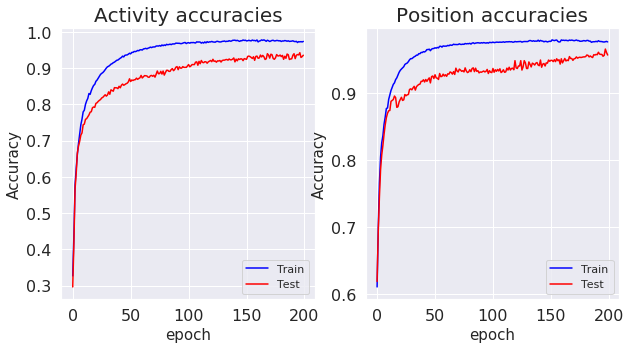

In [35]:
plot_learning_curves(acc_history, '1')

For both activity and position tasks, the learning curves quickly improves along the first 50 epochs. The train curves achieve steady state performance relatively quickly while the test curves maintain a slower improvement rate.
<br>
It can be seen the a further small improvement can be achieved by performing training for more epochs. 


### Confusion Matrices

A better understanding of the model's performance can be gained by analysing the confusion matrix. The matrix columns represent the prediction labels and the rows represent the real label. We focus our attention to the total test set confusion matrix for subjects 1-7 (subject 8-10 will be analysed separately). 

In [36]:
ids_chopped = ['1','2','3','4','5','6','7']
confus1, confus2 = total_confusion_matrix(perform , ids_chopped, 'test', activity_names, position_names)
print(confus1)
print('')
print(confus2)

               biking  downstairs    jogging   standing   upstairs    walking
biking      96.829856    1.083467   0.120385   1.685393   0.120385   0.160514
downstairs   1.364366   95.505618   0.682183   0.200642   0.882825   1.364366
jogging      0.000000    0.963082  98.796148   0.000000   0.240770   0.000000
standing     0.160514    0.000000   0.000000  99.839486   0.000000   0.000000
upstairs     0.642055    0.361156   0.040128   0.802568  87.479936  10.674157
walking      0.361156    5.617978   0.120385   0.000000   5.778491  88.121990

                    Belt  Right_pocket  Upper_arm      Wrist
Belt          100.000000      0.000000   0.000000   0.000000
Right_pocket    0.668807     91.599786   6.848582   0.882825
Upper_arm       0.000000      3.584805  95.318352   1.096843
Wrist           1.043339      0.080257   5.698234  93.178170


Focusing on the activity confusion matrix, we can see that:
* Biking, jogging and standing are the most accurately estimated activities. One can reasonably assume that this activities has the most distinct features. 
* Downstairs, upstairs and walking activities are more difficult to correctly estimate, especially walking and upstairs. It seems that these activities has very similar features which are hard to distinguish apart.        

The position confusion matrix reveals a rather counterintuitive results: The right pocket and the upper arm positions are relativity hard to distinguish.

A deeper understanding of the relationship between activity and position estimation can be achieved by examining the marginal accuracies (i.e, the activity accuracy for a specific position or vice versa):

In [37]:
df = slice_actv_according_to_pos(perform, datasets, positions, activities, ids_chopped, actv_1hot_encode, pos_1hot_encode)
print('Activity accuracies accrding to position:')
print(round(df,2))
print('')
df = slice_pos_according_to_actv(perform, datasets, positions, activities, ids_chopped, actv_1hot_encode, pos_1hot_encode)
print('Position accuracies accrding to activity:')
print(round(df,2))

Activity accuracies accrding to position:
              biking  downstairs  jogging  standing  upstairs  walking
Belt          100.00       93.58    98.72    100.00     91.01    83.31
Right_pocket  100.00       97.91    98.23    100.00     97.27    86.36
Upper_arm      87.64       96.47    98.56     99.84     77.85    91.81
Wrist          99.68       94.06    99.68     99.52     83.79    91.01

Position accuracies accrding to activity:
             Belt  Right_pocket  Upper_arm   Wrist
biking      100.0         92.78      92.62   94.38
downstairs  100.0         99.84      99.84   98.88
jogging     100.0        100.00     100.00   98.56
standing    100.0         57.14      79.45   67.42
upstairs    100.0        100.00     100.00   99.84
walking     100.0         99.84     100.00  100.00


We can see that:
* Jogging and standing are estimated with high accuracy regardless of smartphone position.
* It's relatively hard to correctly identify a biking activity from the upper arm position. Possibly due to the low dynamics of the arm while biking.
* The walking activity has a relatively low accuracy. It seems that in some cases, it's hard to distinguish between walking and the stairs activities. 
* The upstairs accuracy is relatively low for the upper arm and wrist positions. Perhaps some of the subjects used the stairs railings while ascending.  
* While standing, it's hard to correctly identify the smartphone position except for the belt position. While standing, almost all the positions have a similar smartphone orientation. The only position with a distinct different orientation is the Belt (see drawing in the [Dataset section](#Dataset)).

### Low accuracy subjects

When examining the cross validation data it's obvious that subjects 8-10 have low accuracy compared with subjects 1-7:
* Subject 8 has low activity and position accuracy.
* Subject 9 has low position accuracy.
* Subject 10 has low activity accuracy.

It's surprising that 3 consecutive subjects have low accuracy tasks. This may indicated that something changed in the original experiment conducted.

First, let's focus on subject 8. The marginal accuracies are given by:

In [38]:
df = slice_actv_according_to_pos(perform, datasets, positions, activities, '8', actv_1hot_encode, pos_1hot_encode)
print('Activity accuracies accrding to position:')
print(round(df,2))
print('')
df = slice_pos_according_to_actv(perform, datasets, positions, activities, '8', actv_1hot_encode, pos_1hot_encode)
print('Position accuracies accrding to activity:')
print(round(df,2))

Activity accuracies accrding to position:
              biking  downstairs  jogging  standing  upstairs  walking
Belt             0.0         0.0    100.0      0.00      0.00     0.00
Right_pocket   100.0       100.0    100.0    100.00    100.00   100.00
Upper_arm        0.0       100.0    100.0     98.88     98.88    98.88
Wrist          100.0       100.0    100.0     94.38     93.26   100.00

Position accuracies accrding to activity:
            Belt  Right_pocket  Upper_arm   Wrist
biking       0.0         92.13       0.00  100.00
downstairs   0.0        100.00      82.02   98.88
jogging      0.0        100.00     100.00   96.63
standing     0.0         94.38       0.00   83.15
upstairs     0.0        100.00     100.00   95.51
walking      0.0        100.00      61.80  100.00


It's obvious that something was wrong with the Belt position. Activity and position estimation accuracies are poor when the smartphone is located on the belt.
Let's examine a sample time series of a standing activity while the smartphone is on the belt, comparing subject 1 and subject 8:

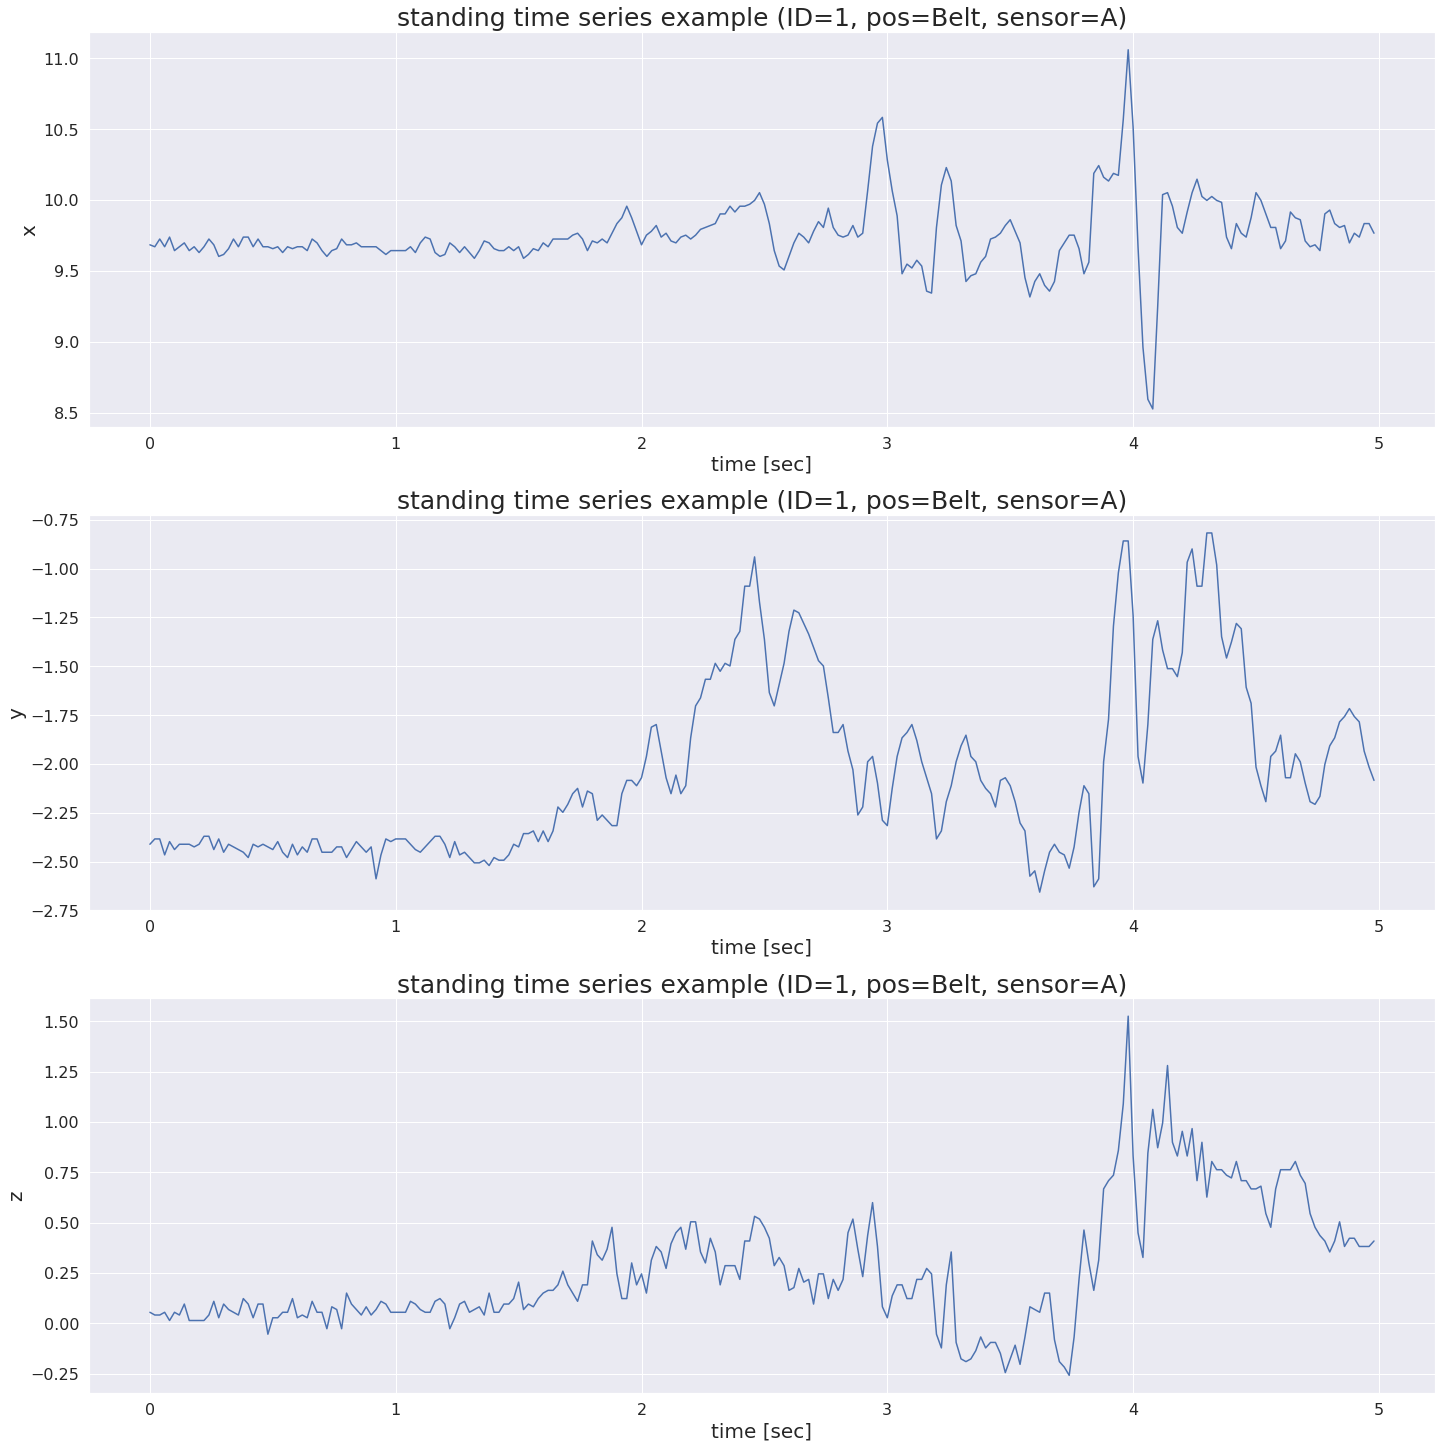

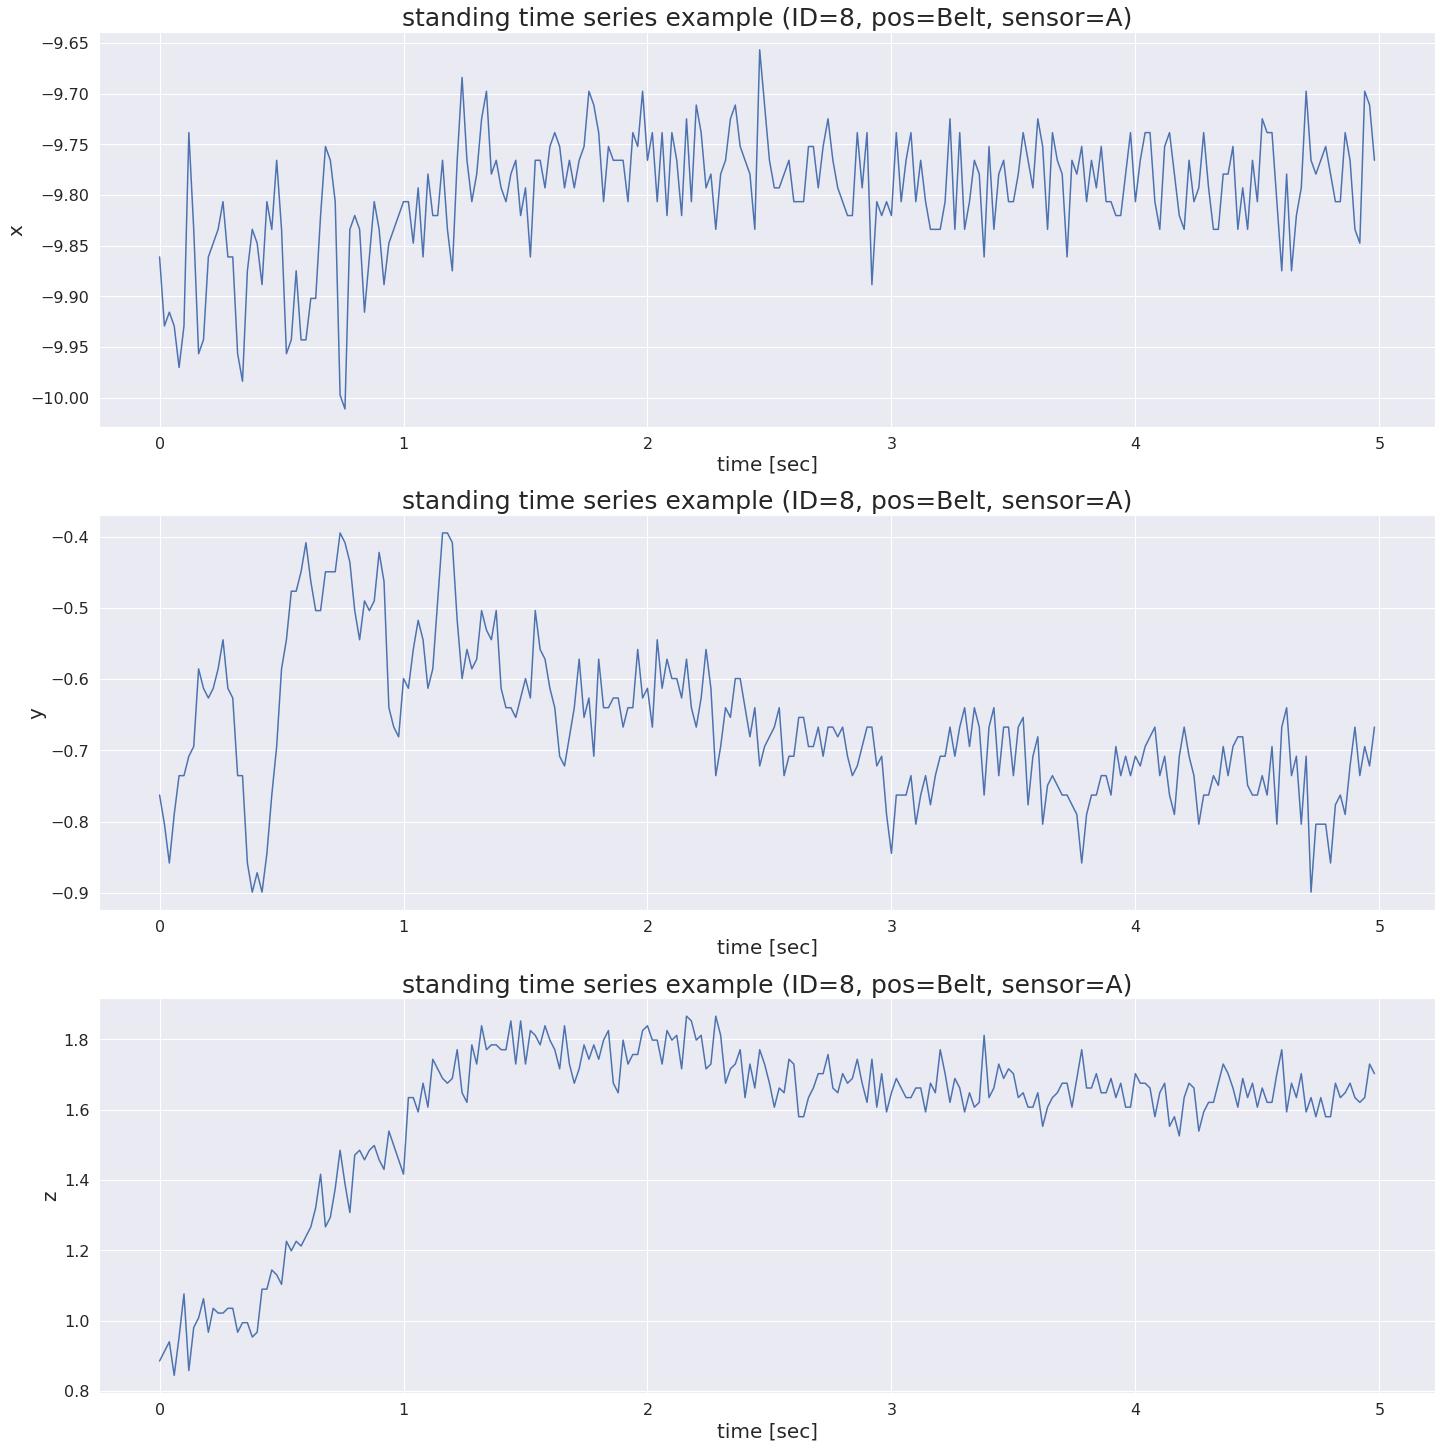

In [39]:
PlotActivity(db, '1', 'Belt', 'standing', 'A', 5.0, dt, 0.5, False)
PlotActivity(db, '8', 'Belt', 'standing', 'A', 5.0, dt, 0.5, False)

Examining the accelerometer X direction it's quiet obvious that subject 8 accelerometer had a different orientation relative to the other subject. One can reasonably assume that this had a large influence on the testing accuracy. 

Subject 9 had low position accuracy. The marginal accuracies are given by:

In [40]:
confus1, confus2 = specific_id_confusion_matrix(perform , '9', 'test', activity_names, position_names)
print('Activity confusion matrix:')
print(confus1)
print('')
print('Position confusion matrix:')
print(confus2)

Activity confusion matrix:
                biking  downstairs    jogging   standing   upstairs    walking
biking      100.000000    0.000000   0.000000   0.000000   0.000000   0.000000
downstairs    1.123596   93.258427   4.775281   0.000000   0.842697   0.000000
jogging       0.000000    0.000000  98.595506   0.000000   1.404494   0.000000
standing      0.280899    0.000000   0.000000  99.719101   0.000000   0.000000
upstairs      0.000000    0.000000   0.000000   0.000000  94.382022   5.617978
walking       0.000000    2.528090   0.000000   0.000000  17.977528  79.494382

Position confusion matrix:
                   Belt  Right_pocket  Upper_arm       Wrist
Belt          69.101124      8.052434  22.846442    0.000000
Right_pocket   0.187266     64.794007   4.119850   30.898876
Upper_arm      0.000000      0.000000  93.632959    6.367041
Wrist          0.000000      0.000000   0.000000  100.000000


Again, something looks wrong with the belt and pocket position. Let's examine a sample time series of a standing activity while the smartphone is on the belt, comparing subject 2 and subject 9:

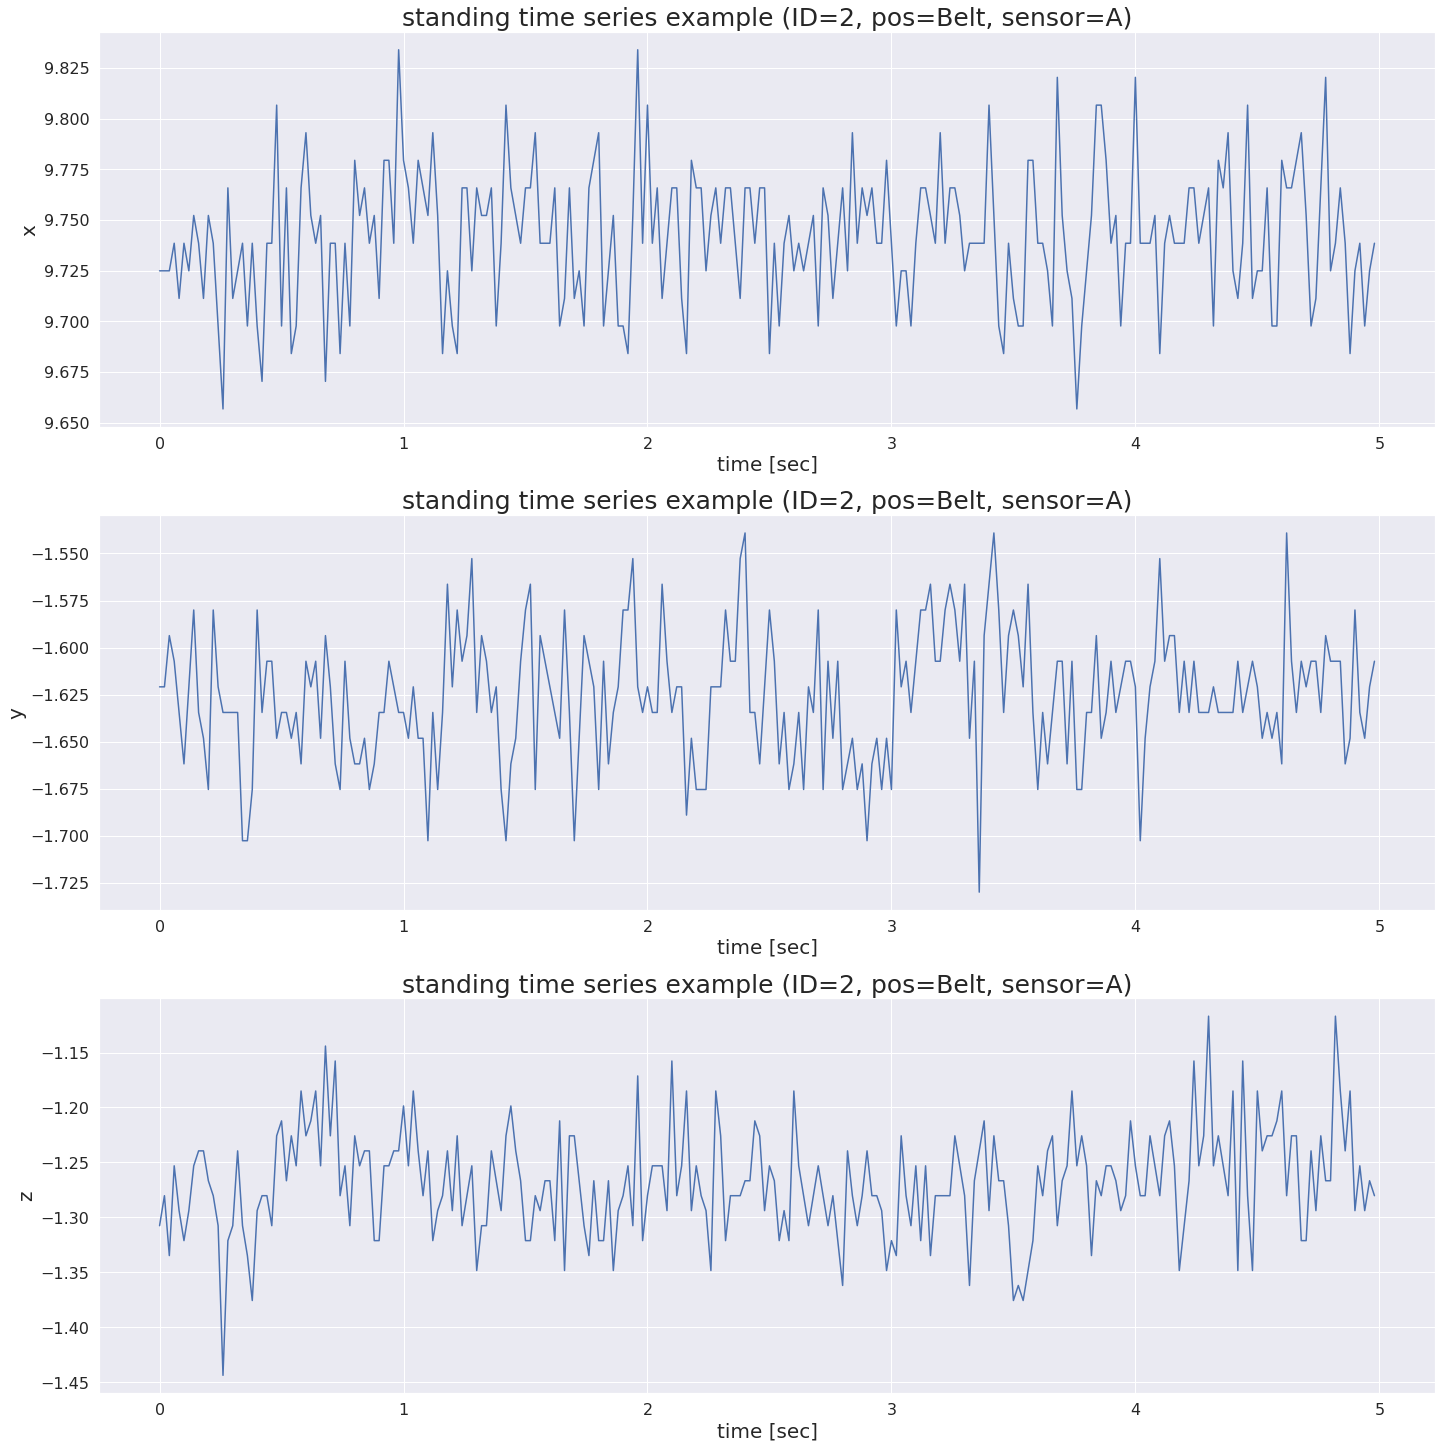

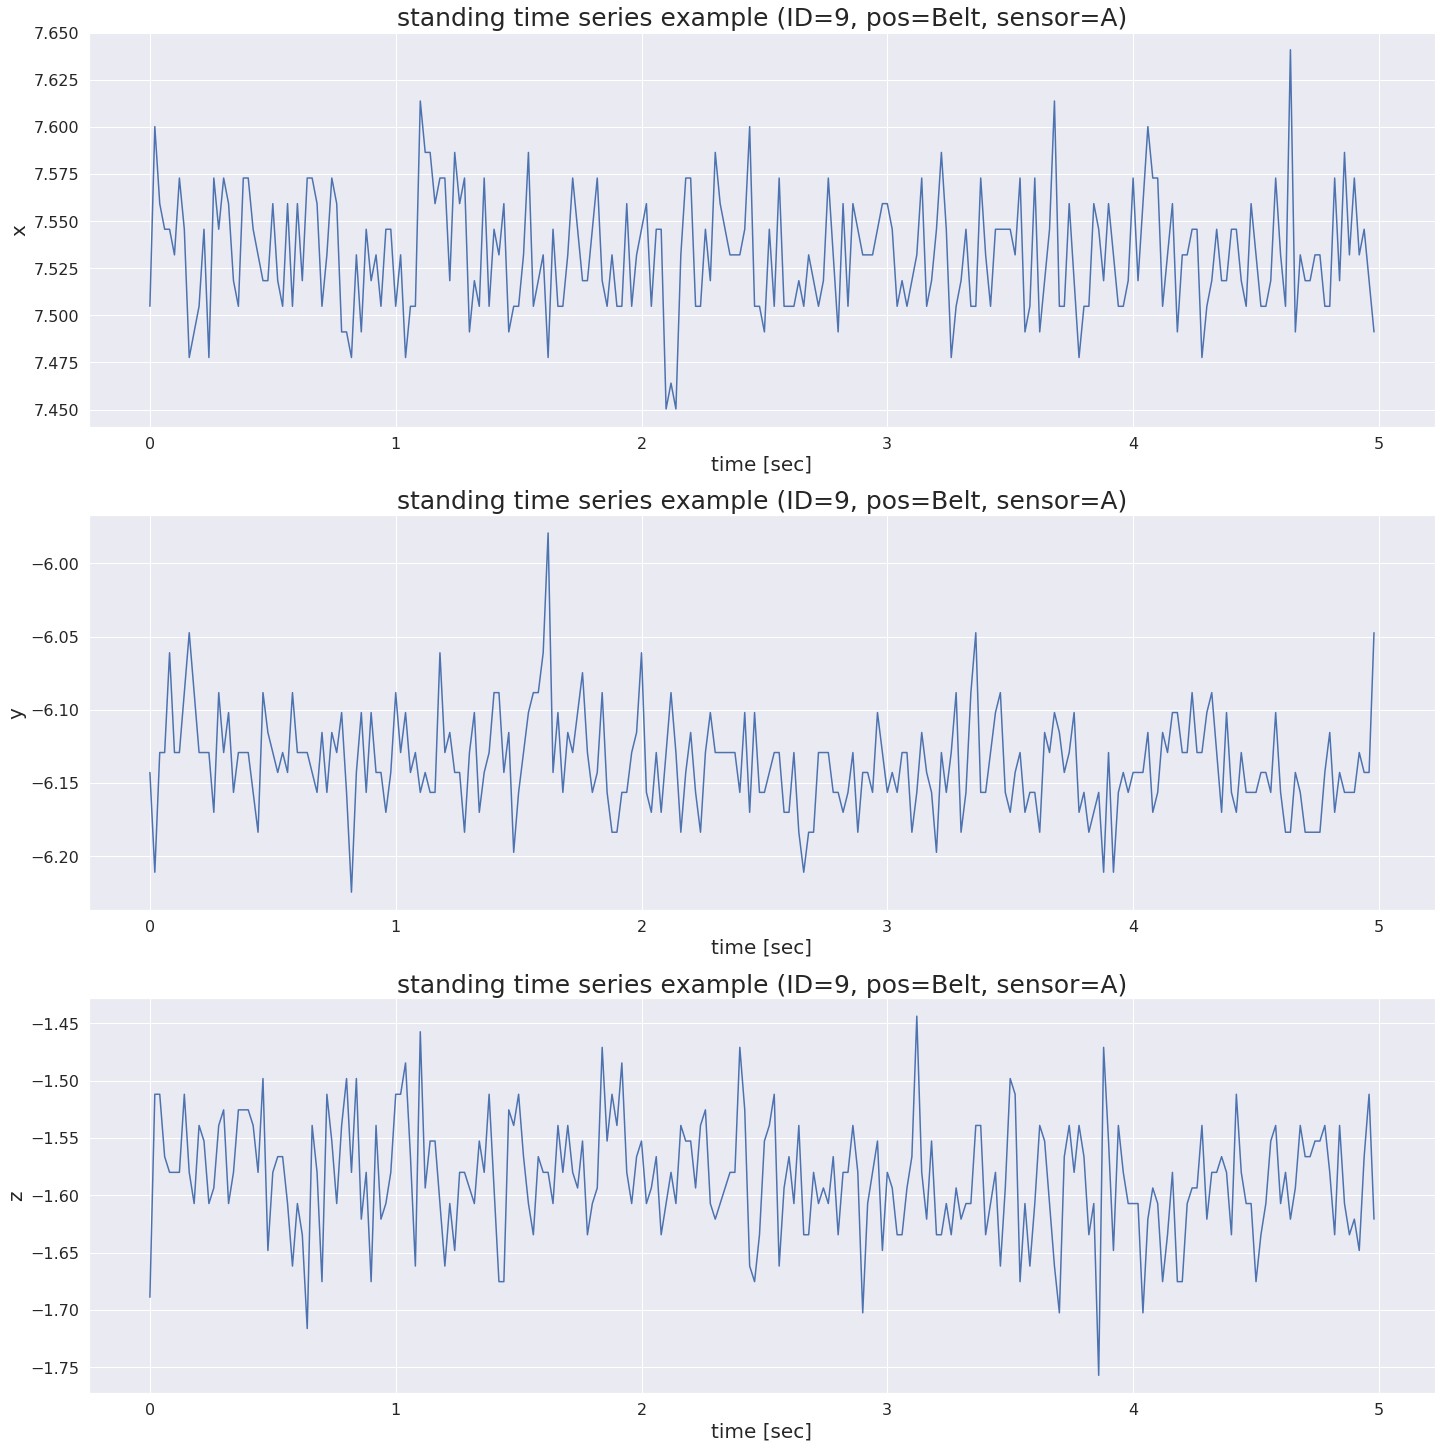

In [41]:
PlotActivity(db, '2', 'Belt', 'standing', 'A', 5.0, dt, 0.1, False)
PlotActivity(db, '9', 'Belt', 'standing', 'A', 5.0, dt, 0.1, False)

Subject 2 accelerometer readings while standing are mainly concentrated on the X direction while subject 9 has large X and Y direction readings. Is seems that the smartphone belt orientation was different from subjects 1-7. It's not obvious why the pocket position accuracy was also very low, perhaps it was a side effect of the belt position problem.

Subject 10 had low activity accuracy. The marginal accuracies are given by:

In [42]:
confus1, confus2 = specific_id_confusion_matrix(perform , '10', 'test', activity_names, position_names)
print('Activity confusion matrix:')
print(confus1)
print('')
print('Position confusion matrix:')
print(confus2)
print('')
df = slice_actv_according_to_pos(perform, datasets, positions, activities, ['10'], actv_1hot_encode, pos_1hot_encode)
print('Activity accuracies accrding to position:')
print(round(df,2))
print('')
df = slice_pos_according_to_actv(perform, datasets, positions, activities, ['10'], actv_1hot_encode, pos_1hot_encode)
print('Position accuracies accrding to activity:')
print(round(df,2))

Activity confusion matrix:
               biking  downstairs    jogging   standing   upstairs    walking
biking      75.000000    1.123596   0.000000  23.876404   0.000000   0.000000
downstairs  10.393258   89.606742   0.000000   0.000000   0.000000   0.000000
jogging      0.280899    0.000000  96.348315   0.000000   3.089888   0.280899
standing     2.808989    0.000000   0.000000  97.191011   0.000000   0.000000
upstairs     0.000000   12.078652   0.000000   0.000000  87.078652   0.842697
walking      0.000000   17.977528   0.000000   5.337079   4.213483  72.471910

Position confusion matrix:
                    Belt  Right_pocket  Upper_arm      Wrist
Belt          100.000000      0.000000   0.000000   0.000000
Right_pocket    0.000000    100.000000   0.000000   0.000000
Upper_arm       0.000000      2.247191  97.752809   0.000000
Wrist           2.247191      0.000000   3.932584  93.820225

Activity accuracies accrding to position:
              biking  downstairs  jogging  standing

It seems that while the smartphone was located on the belt, the model wasn't able to recognize the biking activity. No reason was found to explain this behavior.

## Conclusions and Recommendations

In this work, a multi-task CNN for HAR applications was developed and trained.
The model outputs both human activity and smartphone position.
The model's performance was evaluated using a cross-validation method that can take into account the 'subject sensitivity' issue typical for HAR applications.
<br>
Overall, the network achieved good performance. 

The main findings are:
* Biking, jogging and standing are the most accurately estimated activities.
* Walking, upstairs and downstairs activities are more difficult to correctly estimate.
* There was an average generalization error of 2.5% on a 'hold out' set with the same distribution as the train set.
* There was an average generalization error of 5% on a 'hold out' set comprised of data from a subject unseen during training (e.g: 'subject sensitivity').
* The model was very sensitive to the smartphone orientation:
    * While standing, the model could correctly estimate that the belt positions because it had a distinct orientation compared to other positions.
    * Several subjects had very low position estimation accuracy because their smartphone had a different belt orientation.

Additional improvements can be achieved by:
* Using a dataset with more data, especially more subjects.
* Using a barometer sensor can help differentiate walking, upstairs and downstairs activities by giving an indication of relative height change. 
* A real world HAR application should have an online learning scheme that can better fit the model to the specific user motion patterns.
* If available, the orientation information should be used as an input to the model. alternatively , the sensor data can be converted to a global coordinate system.





<a id="Refs"></a>
## References

[1] - __[Implementing a CNN for Human Activity Recognition in Tensorflow](https://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/)__

[2] - Ronao, Charissa Ann, and Sung-Bae Cho. "Human activity recognition with smartphone sensors using deep learning neural networks." Expert Systems with Applications 59 (2016): 235-244.

[3] -  (a) Shoaib, M. and Bosch, S. and Incel, O.D. and Scholten, H. and Havinga, P.J.M. (2014) Fusion of Smartphone Motion Sensors for Physical Activity Recognition. Sensors, 14, 10146-10176; (b) This data collector is supported by the Dutch national program COMMIT in the context of the SWELL project.

[4] - Su, Xing, Hanghang Tong, and Ping Ji. "Activity recognition with smartphone sensors." Tsinghua science and technology 19.3 (2014): 235-249.

[5] - Wang, Jindong, et al. "Deep learning for sensor-based activity recognition: A survey." Pattern Recognition Letters (2018).

[6] - Coskun, Doruk, Özlem Durmaz Incel, and Atay Ozgovde. "Phone position/placement detection using accelerometer: Impact on activity recognition." ISSNIP. 2015.

[7] - __[Multi-task learning](https://www.coursera.org/lecture/machine-learning-projects/multi-task-learning-l9zia)__